In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [276]:
short_pop_vector

array([33627.720567, 22387.678335, 14408.99769 , 19537.22766 ,
       27289.444286, 36604.60837 , 24699.952982, 22711.676878,
       11238.5265  , 20730.150928, 17504.073704, 18594.056888,
       27783.881553, 19365.418924, 13642.411734, 32007.574021,
       21660.334872, 20934.18406 , 22880.608813, 12795.709134,
       25013.081132,  7807.551336,  8228.8872  , 20580.501846,
       14305.31085 , 10554.652732, 27412.922887, 36424.012276,
       14466.231774, 14425.98459 , 17679.569114, 14024.675548,
       21277.465581, 13876.205764,  7162.1796  , 25124.656641,
       17483.918429, 30427.692541, 11205.28201 , 21621.491482,
       18317.850967, 16699.992156, 21958.021048, 22591.673064,
       19721.7333  , 25657.953988, 27487.832812, 21472.608006,
       26538.02244 , 23690.039544, 19480.309064, 23085.92196 ,
       28498.772216, 14882.59494 , 19990.448512, 12857.63625 ,
        9962.28705 , 14958.342735, 13025.84793 ,  9295.5948  ,
       19506.513332,  7279.353745, 12738.784286, 10337.

In [38]:
all_station_timeseries.shape

(78, 8)

In [348]:
pop_dict2 = dict(sorted(pop_dict.items()))
pop_dict2

{'9 DE JULIO': 3885.8633999999997,
 'ACOYTE': 23085.92196,
 'AGUERO': 18317.850967,
 'ALBERTI': 7807.551336,
 'ANGEL GALLARDO': 28498.772215999998,
 'AV. DE MAYO': 2514.3822,
 'AV. LA PLATA': 36604.60837,
 'BELGRANO': 10952.801249999999,
 'BOEDO': 36424.012275999994,
 'BULNES': 17483.918429,
 'CALLAO': 21922.347559,
 'CALLAO - MAESTRO ALFREDO BRAVO': 7279.353745,
 'CARABOBO': 21958.021048,
 'CARLOS GARDEL': 21621.491481999998,
 'CASEROS': 14425.98459,
 'CASTRO BARROS': 22711.676878,
 'CATALINAS': 7162.1795999999995,
 'CATEDRAL': 4247.78205,
 'CONGRESO': 12738.784285999998,
 'CONGRESO DE TUCUMAN': 33627.720567000004,
 'CONSTITUCION': 20580.501846,
 'CORDOBA': 14958.342735,
 'CORRIENTES': 11205.282009999999,
 'DE LOS INCAS PARQUE CHAS': 17504.073704000002,
 'DORREGO': 19480.309064,
 'ECHEVERRIA': 14408.99769,
 'EMILIO MITRE': 20934.18406,
 'ENTRE RIOS RODOLFO WALSH': 19506.513332000002,
 'F. LACROZE': 16699.992156,
 'FACULTAD DE DERECHO JULIETA LANTERI': 27783.881553,
 'FACULTAD DE MEDIC

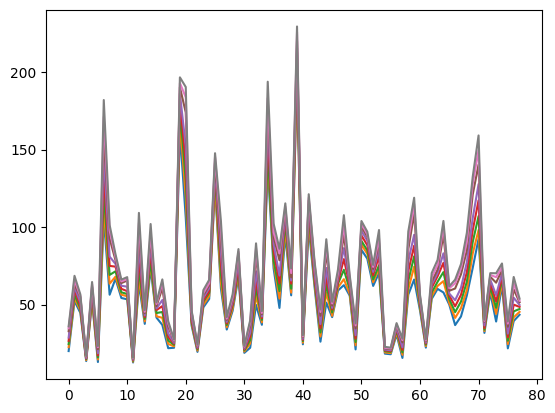

In [39]:
plt.plot(all_station_timeseries)

In [2]:
def expand_array(short_array):
    long_array = np.zeros(6084)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(78) * (78 + 1)] = short_array
    return long_array

def expand_timeseries(short_timeseries):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((day_range,6084))
    for i in range(day_range):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries


def compress_timeseries(long_timeseries):
    compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape
    
    for i in range(day_range):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def compress_array(long_array):
    return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas



with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
    pop_dict = pickle.load(file)
    
# Assuming pop_dict is a pandas DataFrame
pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
pop_dict = dict(sorted(pop_dict.items()))

# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
borough_list = np.array(range(15))+1
    
with open("ba_big station list.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("station_comuna_dict.pkl", 'rb') as f:
    station_comuna_dict = pickle.load(f)
    
station_borough_list = list(station_comuna_dict.values())
    
with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("BA_Covid_Data.pkl", 'rb') as f:
    covid_df = pickle.load(f)
    
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values

    
with open("ba_all_paths.pkl", 'rb') as f:
    all_paths = pickle.load(f)
    
# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
    
    
################################################################################################
################################################################################################
################################################################################################
################################################################################################

def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-08-07") & 
        (covid_df['comuna'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-07-23"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-08-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    
    
    return station_timeseries

def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-11-30"
    earliest_nonzero_date = "2020-04-05"
    five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]
print(day_range)

working_timeseries = expand_timeseries(all_station_timeseries)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)
    
with open("Buenos Aires Home Patches.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
# Load files
with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)
    
with open("Fixed Sparse Buenos Aires P-Matrix.pkl","rb") as file:
    fixed_sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
fixed_p_matrix = fixed_sparse_p.toarray()
Nj = pop_vector @ p_matrix

Nj_safe = Nj.copy()
Nj_safe[Nj_safe == 0] = 1
Nj = Nj_safe.copy()

with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

np.set_printoptions(suppress=True)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

current_cases,cum_cases

/tmp/ipykernel_2321699/3242829437.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


240


(array([0.53309146, 3.06198276, 1.36098964, 0.84738171, 2.87982388,
        0.34494154, 3.1537043 , 1.50258624, 3.68067577, 2.53600832,
        1.62879848, 0.79005452, 1.89181386, 2.34665845, 3.49440066,
        2.29503324, 0.98256074, 0.58274214, 1.3825862 , 6.35516468,
        2.82338537, 1.11138307, 1.21614967, 1.61165043, 1.7936081 ,
        6.26534752, 1.80360422, 2.11711224, 1.53761633, 2.06430192,
        1.17870608, 0.59058172, 1.32750228, 2.30932008, 6.64022169,
        3.50414972, 1.27523841, 3.72712931, 3.27605848, 9.73465248,
        1.52214862, 3.91770601, 1.86672538, 0.69510946, 1.36670018,
        2.31210395, 1.9770448 , 1.86616643, 3.07474284, 0.56183659,
        3.98705662, 3.72163626, 2.89957563, 3.36122794, 1.14553453,
        1.12199615, 1.9188274 , 0.41549776, 1.68324814, 1.76390558,
        2.15869142, 1.38876446, 3.14210942, 3.51984935, 1.54178414,
        2.75762032, 0.97994755, 1.12889957, 1.6684458 , 1.96250828,
        2.7576425 , 0.96780152, 2.69703174, 1.04

In [16]:
short_pop_vector

array([ 3885.8634  , 23085.92196 , 18317.850967,  7807.551336,
       28498.772216,  2514.3822  , 36604.60837 , 10952.80125 ,
       36424.012276, 17483.918429, 21922.347559,  7279.353745,
       21958.021048, 21621.491482, 14425.98459 , 22711.676878,
        7162.1796  ,  4247.78205 , 12738.784286, 33627.720567,
       20580.501846, 14958.342735, 11205.28201 , 17504.073704,
       19480.309064, 14408.99769 , 20934.18406 , 19506.513332,
       16699.992156, 27783.881553, 10860.286618,  4304.9271  ,
        9676.5618  , 21277.465581, 27412.922887, 14466.231774,
        9295.5948  , 19721.7333  , 24699.952982, 22387.678335,
       14024.675548, 20730.150928, 25124.656641,  5066.8611  ,
        9962.28705 , 22880.608813, 21472.608006, 21660.334872,
       30427.692541,  4095.39525 , 27487.832812, 25657.953988,
       19990.448512, 13876.205764, 10554.652732, 10337.776306,
       17679.569114,  3028.68765 , 19537.22766 , 12857.63625 ,
       14882.59494 , 12795.709134, 23690.039544, 26538.

In [3]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]


def run_model_London(params):
    S0,I0,I_total0,beta0,gamma,timesteps = params
    
    beta = expand_concise_betas(home_patches,travel_patches,beta0)
    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        # print("step:",step)
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

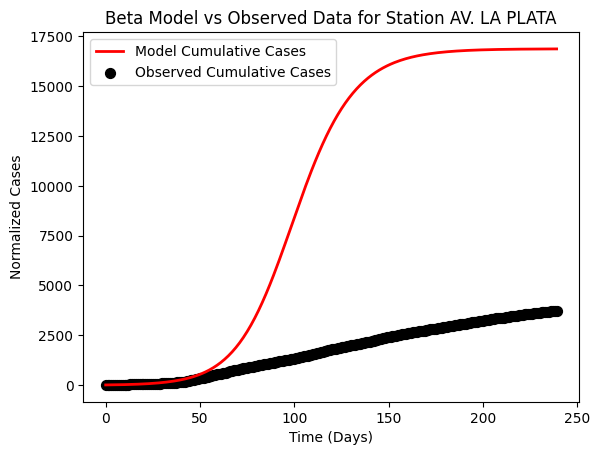

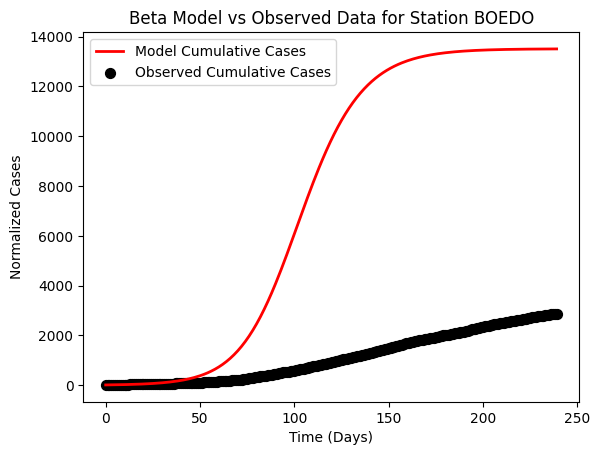

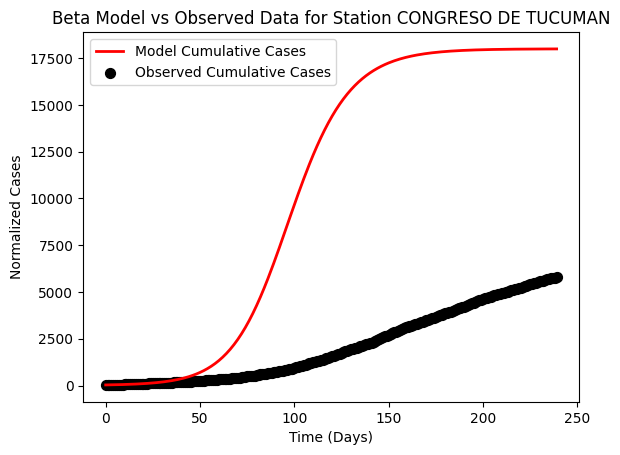

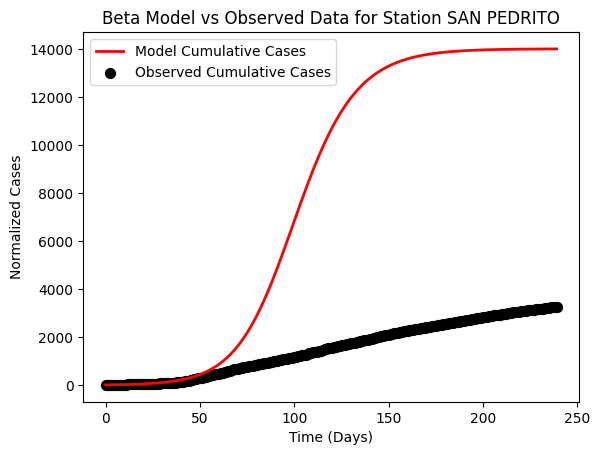

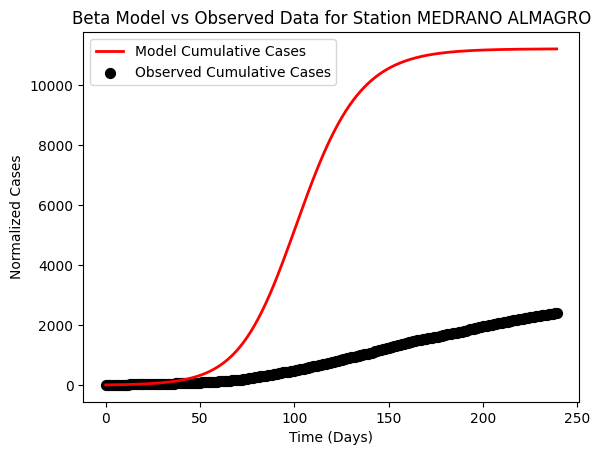

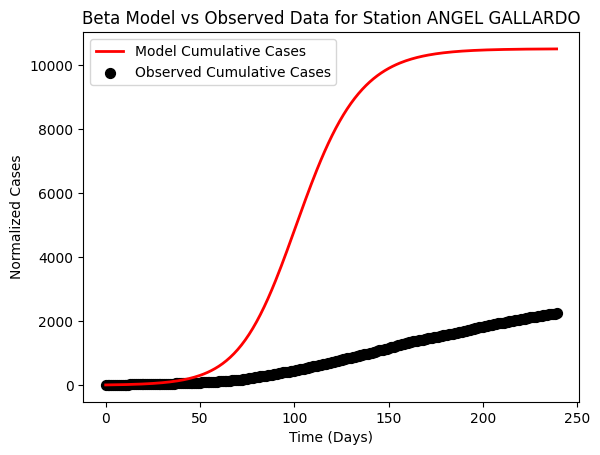

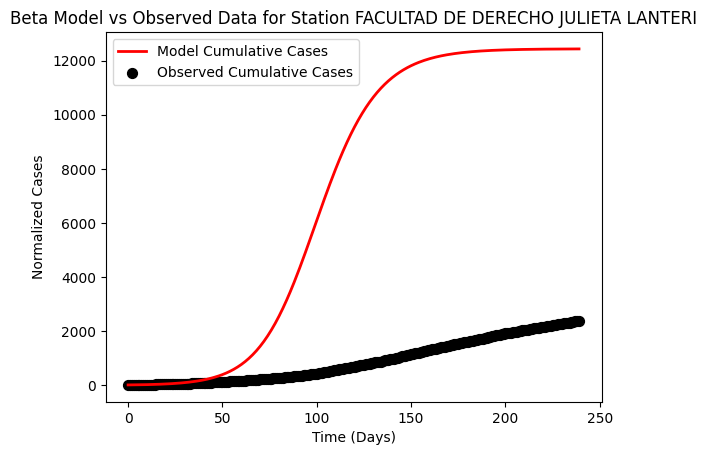

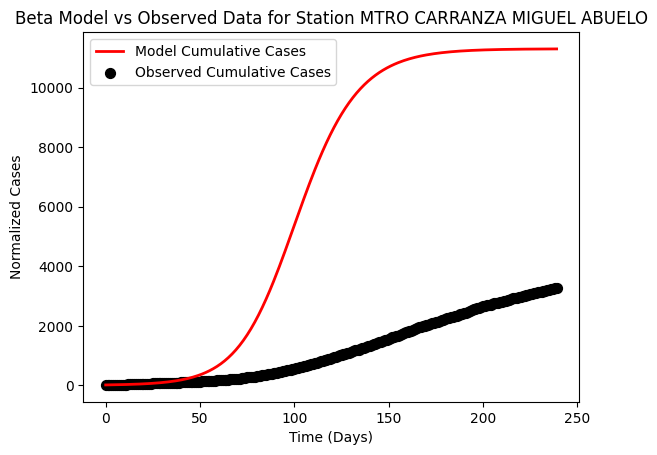

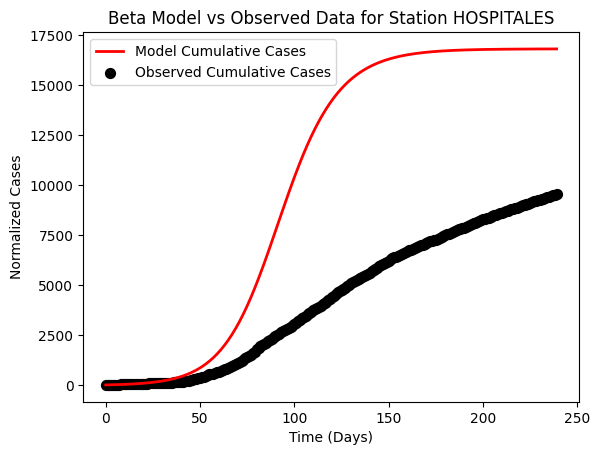

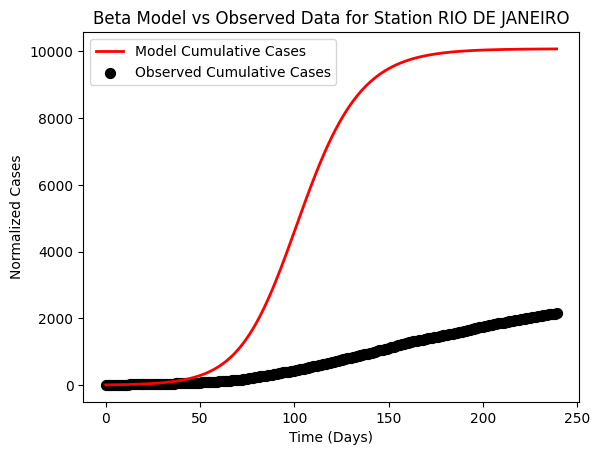

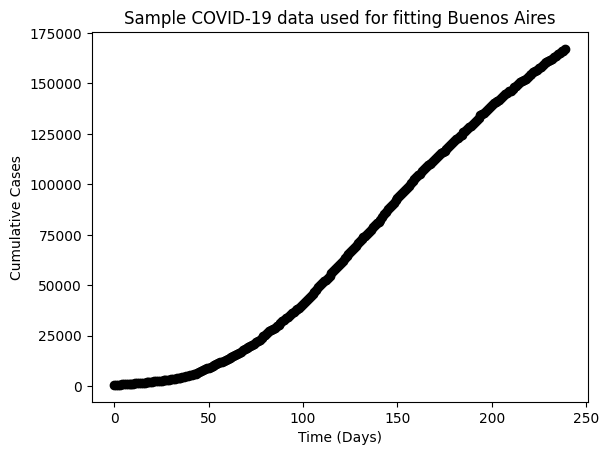

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

# Load best beta values
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet = pickle.load(file)
    
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
# best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)

    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    # normalizer = short_pop_vector
    # test_data = I_sum_model / normalizer[:, np.newaxis]
    # real_data = raw_real_data / normalizer[:, np.newaxis]
    test_data = I_sum_model
    real_data = raw_real_data
    
    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    for i in top_10_indices:
        plt.figure()
        plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        plt.xlabel('Time (Days)')
        plt.ylabel('Normalized Cases')
        plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        plt.legend()
        plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    plt.scatter(data[:, 0], summed_real, color='k', label='Total Observed Cumulative Cases')
    plt.xlabel('Time (Days)')
    plt.ylabel('Cumulative Cases')
    plt.title('Sample COVID-19 data used for fitting Buenos Aires')
    plt.show()
    # from sklearn.metrics import r2_score
    # r2 = r2_score(summed_real, summed_model)
    # plt.title(f'Total Model vs Observed Data Across All Patches\n$R^2$ = {r2:.4f}')

    # plt.legend()
    plt.show()

        
    return np.array(solution),params

solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

(240, 6085)


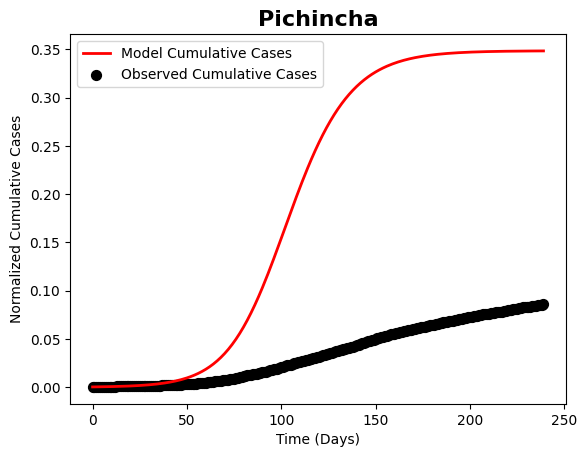

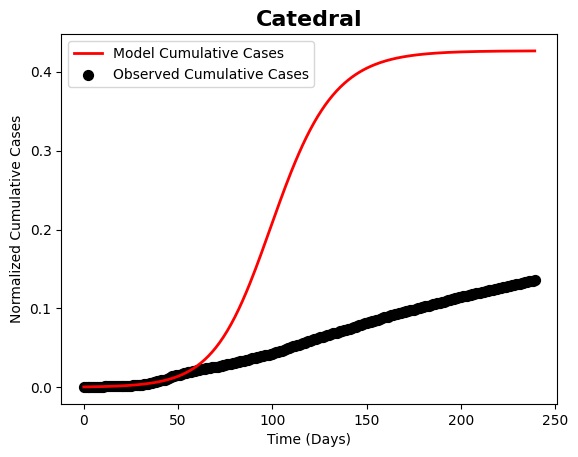

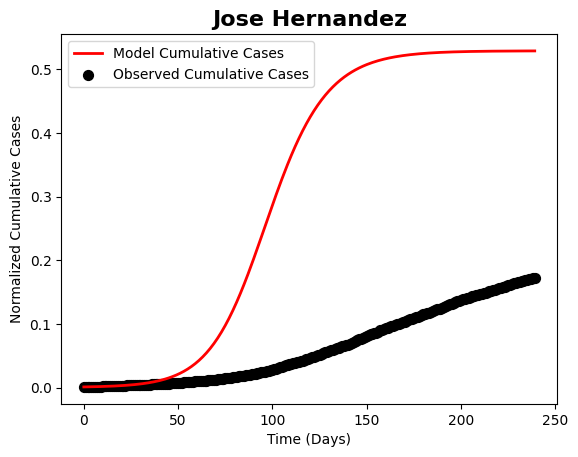

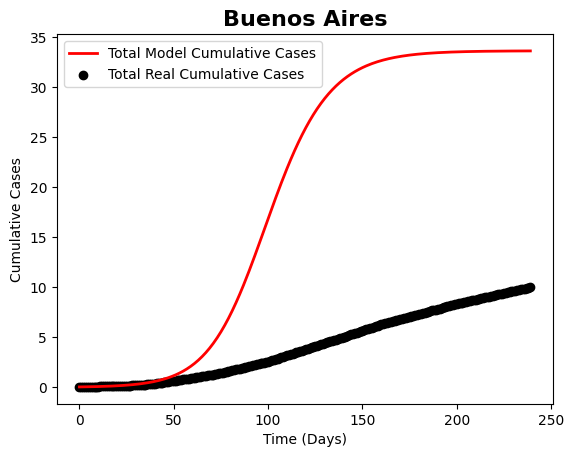

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

# Load best beta values
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet = pickle.load(file)
    
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
# best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def compute_fit_error(model_data, real_data):
    """Compute error as the sum of absolute differences between model and real data."""
    return np.sum(np.abs(model_data - real_data), axis=1)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    print(data.shape)

    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = short_pop_vector
    test_data = I_sum_model / normalizer[:, np.newaxis]
    real_data = raw_real_data / normalizer[:, np.newaxis]
    # test_data = I_sum_model
    # real_data = raw_real_data
    
    
    # Get indices of the 10 stations with the highest total populations
    errors = compute_fit_error(test_data, real_data)
    sorted_indices = np.argsort(errors)  # Sort from best (lowest error) to worst (highest error)
    

    # Plot all 251 stations in sorted order
    for rank, i in enumerate(sorted_indices[0:251]):
        if station_list[i] in ["PICHINCHA","JOSE HERNANDEZ","CATEDRAL"]:
            plt.figure()
            plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
            plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

            plt.xlabel('Time (Days)')
            plt.ylabel('Normalized Cumulative Cases')
            plt.title(f'{station_list[i].title()}', fontweight='bold',fontsize=16)
            plt.legend()
            plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    plt.figure()
    plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    plt.scatter(data[:, 0], summed_real, color='k', label='Total Real Cumulative Cases')
    plt.xlabel('Time (Days)')
    plt.ylabel('Cumulative Cases')
    plt.title('Buenos Aires',fontweight='bold',fontsize=16)
    plt.legend()
    plt.show()

        
    return np.array(solution),params

solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [322]:
station_list.index("SAN JUAN")

69

In [327]:
cum_cases[home_patches][70]

np.float64(9.651748758336502)

In [326]:
current_cases[70]

np.float64(2.757642502381858)

In [325]:
cum_cases[home_patches][69]

np.float64(7.314803607008497)

In [328]:
current_cases[69]

np.float64(1.9625082848071578)

In [295]:
station_list.index("SAN PEDRITO")

70

In [344]:
short_pop_vector[70]

np.float64(3885.8633999999997)

In [330]:
short_pop_vector[69]

np.float64(4095.3952499999996)

In [334]:
best_beta_yet[69]

np.float64(0.3893696623577743)

In [343]:
all_station_timeseries[69]

array([ 7.31480361,  8.02844298,  8.65287744,  9.81254142, 10.5261808 ,
       10.97220541, 11.41823002, 11.86425463, 12.39948416, 13.02391862,
       13.82676292, 14.9864269 , 16.05688597, 16.41370565])

In [298]:
props_dict

{'CONGRESO DE TUCUMAN': [np.int64(13), np.float64(0.453940334320867)],
 'JUAN MANUEL DE ROSAS VILLA URQUIZA': [np.int64(12),
  np.float64(0.6084157797239513)],
 'ECHEVERRIA': [np.int64(12), np.float64(0.3915842202760486)],
 'PLAZA DE LOS VIRREYES EVA PERON': [7, np.float64(0.10520300862730615)],
 'RIO DE JANEIRO': [np.int64(5), np.float64(0.16221296011635794)],
 'AV. LA PLATA': [np.int64(7), np.float64(0.19710651875304364)],
 'JOSE MARIA MORENO': [np.int64(6), np.float64(0.25200449810161524)],
 'CASTRO BARROS': [np.int64(5), np.float64(0.13500195522400762)],
 'RETIRO': [np.int64(1), np.float64(0.07008109720592078)],
 'JURAMENTO': [np.int64(13), np.float64(0.2798361436371915)],
 'DE LOS INCAS PARQUE CHAS': [np.int64(15), np.float64(0.17907226985376082)],
 'SCALABRINI ORTIZ': [np.int64(14), np.float64(0.14983509690474164)],
 'FACULTAD DE DERECHO JULIETA LANTERI': [np.int64(2),
  np.float64(0.22936687945048792)],
 'SAN JOSE DE FLORES': [np.int64(7), np.float64(0.10427786222218641)],
 'VAR

In [338]:
best_beta_yet[70]

np.float64(0.7999584590165756)

In [56]:
current_cases

array([ 15.16887532,  49.46279849,  39.31747836,  12.55665618,
        48.4488018 ,   9.81515462,  92.24585078,  42.75540837,
        61.92195713,  51.70639191,  47.05417832,  11.70717146,
        55.33555536,  34.77321158,  66.59916544,  38.61055919,
        27.95831921,  16.58166273,  20.48741372, 147.98454899,
        80.33814737,  32.106622  ,  18.02112692,  44.76806746,
        49.82244734, 115.12576076,  52.75542356,  31.37175416,
        42.71156464,  59.63538866,  17.46628093,  16.80473442,
        37.77347383,  34.2199248 , 126.5548133 ,  66.78497105,
        36.28632919,  86.78886819,  52.9209446 , 178.87423924,
        22.55547498,  91.22658283,  53.92762206,  19.7790237 ,
        38.88883231,  38.89774875,  54.91791112,  54.585368  ,
        51.72802653,  15.98680487,  81.29165449,  75.88002826,
        59.11912535,  64.06105022,  16.9747389 ,  16.6259429 ,
        28.43353327,  11.82279988,  49.23500804,  50.19113157,
        44.01331942,  20.57896429,  50.7571521 ,  56.85

In [55]:
cum_cases[home_patches]

array([ 16.45314112,  51.11155844,  41.73701549,  12.82627763,
        50.14281585,  10.64615014,  97.56772678,  46.37527521,
        64.08706053,  52.41083867,  49.94982006,  11.95855244,
        58.52799125,  35.51987564,  68.65469523,  39.96057875,
        30.32539736,  17.98554152,  20.92732751, 152.52395233,
        87.1399394 ,  34.08241412,  18.40808363,  45.84250108,
        51.01818608, 118.25843452,  55.79900569,  32.04538078,
        43.73664219,  63.30525873,  17.84132378,  18.22749948,
        40.97154749,  34.95470846, 130.46082605,  68.84623558,
        39.35849444,  89.45110341,  54.68497609, 183.74156548,
        23.039795  ,  94.02494426,  57.24624495,  21.45360558,
        42.18133728,  40.2578099 ,  56.23594098,  57.73452385,
        53.53669878,  17.3403203 ,  82.39917022,  76.91381611,
        59.92456302,  66.03824313,  17.33922716,  16.98294167,
        29.04406927,  12.82377175,  52.07548927,  54.44054047,
        44.61295593,  21.02084389,  52.44905717,  58.75

In [320]:
sorted_stations = [station for _, station in sorted(zip(best_beta_yet, station_list), reverse=True)]
print(sorted_stations)


['SAN PEDRITO', 'HOSPITALES', 'SAN JOSE DE FLORES', 'TRIBUNALES TEATRO COLON', 'SCALABRINI ORTIZ', 'CONGRESO DE TUCUMAN', 'JUAN MANUEL DE ROSAS VILLA URQUIZA', 'VARELA', 'TRONADOR VILLA ORTUZAR', 'VENEZUELA', 'SAN JUAN', 'ECHEVERRIA', 'SANTA FE CARLOS JAUREGUI', 'CASEROS', 'PARQUE PATRICIOS', 'JURAMENTO', 'CORDOBA', 'DORREGO', 'FACULTAD DE DERECHO JULIETA LANTERI', 'RIO DE JANEIRO', 'BOEDO', 'F. LACROZE', 'AV. LA PLATA', 'PLAZA DE LOS VIRREYES EVA PERON', 'PLAZA DE MAYO CASA ROSADA', 'PUAN', 'INCLAN MEZQUITA AL AHMAD', 'PLAZA MISERERE', 'PRIMERA JUNTA', 'AGUERO', 'JOSE MARIA MORENO', 'CALLAO', 'MEDALLA MILAGROSA', 'MTRO CARRANZA MIGUEL ABUELO', 'LAS HERAS', 'DE LOS INCAS PARQUE CHAS', 'PICHINCHA', 'JOSE HERNANDEZ', 'MALABIA O. PUGLIESE', 'RETIRO', 'OLLEROS', 'GRAL. URQUIZA', 'EMILIO MITRE', 'CARABOBO', 'CORRIENTES', 'MEDRANO ALMAGRO', 'SAN JOSE', 'BULNES', 'ANGEL GALLARDO', 'ACOYTE', 'URUGUAY', 'LORIA', 'CARLOS GARDEL', 'CONSTITUCION', 'PLAZA ITALIA', 'CASTRO BARROS', 'PALERMO', 'BELGR

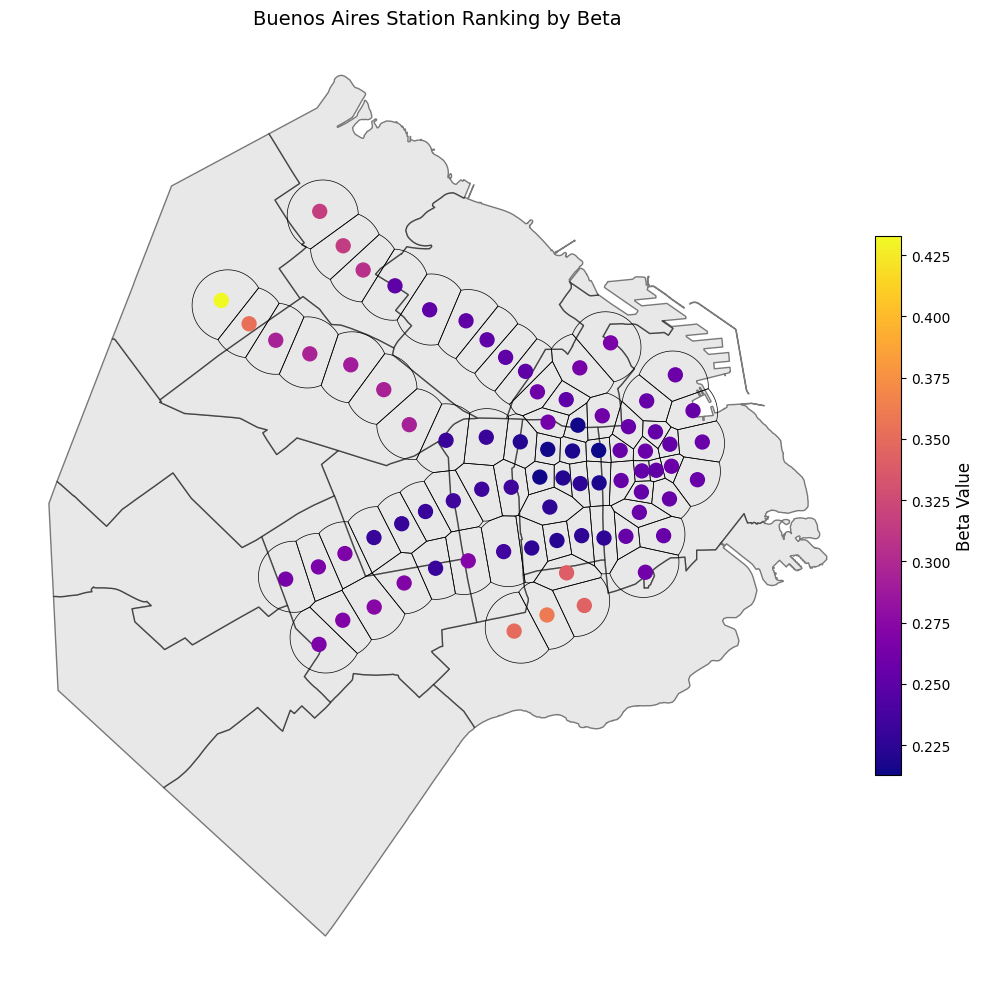

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Attach betas to GeoDataFrame
station_gdf["beta"] = best_beta_yet[:78]

# Normalize for colormap
norm = mcolors.Normalize(vmin=min(best_beta_yet), vmax=max(best_beta_yet))
cmap = plt.cm.plasma

# Compute centroids
station_gdf["centroid"] = station_gdf.geometry.centroid

# Plot base map
fig, ax = plt.subplots(figsize=(10, 10))
borough_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
station_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, markersize=20)

# Plot stations colored by beta
station_gdf["centroid"].plot(
    ax=ax,
    color=[cmap(norm(b)) for b in station_gdf["beta"]],
    markersize=100,
    zorder=3,
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Beta Value", fontsize=12)

ax.set_title("Buenos Aires Station Ranking by Beta", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
train_stations = ["JUAN MANUEL DE ROSAS VILLA URQUIZA", ]

In [354]:
with open("Unrestricted Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta = pickle.load(file)
    
best_beta

array([0.08550388, 0.22150012, 0.28299976, 0.15344685, 0.22180856,
       0.09821763, 0.30710149, 0.19514308, 0.31946514, 0.22635285,
       0.27997829, 0.12633199, 0.23641559, 0.21551922, 0.34978509,
       0.196848  , 0.16641015, 0.09380205, 0.15778635, 0.52092148,
       0.21585029, 0.34203201, 0.24056992, 0.27229153, 0.33461983,
       0.37990794, 0.24095347, 0.17529897, 0.31519975, 0.33317696,
       0.1539632 , 0.13185857, 0.18903768, 0.25080013, 0.57583065,
       0.28808697, 0.17494001, 0.2548683 , 0.28114406, 0.4330049 ,
       0.18678336, 0.34692473, 0.27284562, 0.13795579, 0.16429522,
       0.21220985, 0.25504314, 0.27384916, 0.22880239, 0.13319716,
       0.27606127, 0.25146029, 0.20154171, 0.34871573, 0.17374678,
       0.18411065, 0.26306758, 0.13148801, 0.31116949, 0.30351337,
       0.21238413, 0.29199799, 0.28354865, 0.29812824, 0.25886143,
       0.33462148, 0.15736173, 0.22995923, 0.56089233, 0.38946667,
       0.99      , 0.36051188, 0.52263984, 0.54832333, 0.42039

In [270]:
station_list[70]

'SAN PEDRITO'

In [126]:
borough_gdf

id  objeto  comuna                                            barrios  \
0    1  COMUNA       1  CONSTITUCION, MONSERRAT, RETIRO, PUERTO MADERO...   
1    2  COMUNA       2                                           RECOLETA   
2    3  COMUNA       3                           SAN CRISTOBAL, BALVANERA   
3    4  COMUNA       4    BARRACAS, BOCA, PARQUE PATRICIOS, NUEVA POMPEYA   
4    5  COMUNA       5                                     ALMAGRO, BOEDO   
5    6  COMUNA       6                                          CABALLITO   
6    7  COMUNA       7                           FLORES, PARQUE CHACABUCO   
7    8  COMUNA       8       VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI   
8    9  COMUNA       9              PARQUE AVELLANEDA, MATADEROS, LINIERS   
9   10  COMUNA      10  FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERSA...   
10  11  COMUNA      11  VILLA DEL PARQUE, VILLA DEVOTO, VILLA GRAL. MI...   
11  12  COMUNA      12  VILLA URQUIZA, VILLA PUEYRREDON, SAAVEDRA, COG...   
12  13  COMUNA      13                        BELGRANO, NUÑEZ, COLEGIALES   
13  14  COMUNA      14                                            PALERMO   
14  15  COMUNA      15  AGRONOMIA, PATERNAL, PARQUE CHAS, CHACARITA, V...   

    perimetro         area                                           geometry  
0    36011.96  17784744.41  MULTIPOLYGON (((-6497556.719 -4106091.751, -64...  
1    21450.47   6317725.62  POLYGON ((-6498832.76 -4105601.489, -6498835.1...  
2    10486.26   6385991.48  POLYGON ((-6502385.341 -4109384.6, -6502204.48...  
3    35474.12  21688665.28  POLYGON ((-6496071.732 -4112282.635, -6496064....  
4    12323.43   6660603.14  POLYGON ((-6502491.213 -4111563.827, -6502485....  
5    10990.96   6851028.91  POLYGON ((-6504465.476 -4110607.718, -6504460....  
6    17972.26  12422900.83  POLYGON ((-6506846.416 -4113678.027, -6506799....  
7    20943.00  22218817.04  POLYGON ((-6506527.687 -4116576.219, -6506493....  
8    21411.74  16505305.78  POLYGON ((-6514333.314 -4114119.735, -6514314....  
9    18332.04  12656556.95  POLYGON ((-6510891.839 -4112381.421, -6510876....  
10   19987.70  14120006.74  POLYGON ((-6512010.291 -4109163.499, -6511875....  
11   17232.19  15570926.64  POLYGON ((-6512558.684 -4108823.88, -6512576.5...  
12   26156.29  14817905.82  POLYGON ((-6507606.169 -4101155.126, -6507576....  
13   22800.36  15849480.77  POLYGON ((-6503863.661 -4103056.777, -6503919....  
14   17832.59  14322896.78  POLYGON ((-6503955.465 -4109196.772, -6503823....

In [7]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm
import IPython
import base64

def embed_gif_base64(gif_path):
    with open(gif_path, "rb") as f:
        gif_data = f.read()
    b64_gif = base64.b64encode(gif_data).decode("utf-8")
    return HTML(f'<img src="data:image/gif;base64,{b64_gif}" style="display:block;margin:0 auto;" autoplay loop>')


# Load Buenos Aires Voronoi and borough data
station_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
# Ensure CRS consistency
borough_gdf = gpd.read_file("comunas.shp")
station_gdf = station_gdf.to_crs(epsg=3857)  
borough_gdf = borough_gdf.to_crs(epsg=3857)

pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif_ba(solution, params, pop_array, label_mode="number"):
    """
    Generates a GIF of the Buenos Aires disease spread simulation using Voronoi coloring 
    while maintaining black station dots, ensuring boroughs are drawn behind. Includes a label at the top.

    Parameters:
    - solution: The output of the disease model simulation.
    - params: Model parameters including timesteps.
    - pop_array: Population array for normalization.
    - label_mode: "date" (MM/DD/YYYY format) or "number" (time index).
    """
    output_filename = "buenos_aires_voronoi_disease.gif"

    # Extract station data and normalize by population
    map_data = solution
    station_data = map_data[1][home_patches]
    
    num_timesteps = station_data.shape[1]
    for i in range(len(station_data)):
        station_data[i] = station_data[i] / pop_array[i]


    # Define start date for label_mode="date"
    start_date = datetime(2020, 4, 5)

    # Temporary storage for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []

        # Progress bar
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            # Normalize the color values for better colormap utilization
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)

            # Avoid division by zero if all values are the same
            if color_max > color_min:
                station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                station_gdf["color"] = 0.5  # Set to mid-range if all values are identical

            # Create figure with increased size
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot boroughs first (grey background, borders retained)
            borough_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

            # Plot Voronoi regions with edges
            station_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            
            # Plot stations as black dots
            # station_gdf.centroid.plot(ax=ax, color="black", markersize=1)
            station_gdf["centroid"] = station_gdf.geometry.centroid  # Compute centroids
            station_gdf["centroid"] = station_gdf["centroid"].to_crs(epsg=3857)  # Ensure projected CRS
            station_gdf["centroid"].plot(ax=ax, color="black", markersize=1)  # Plot centroids


            # Generate label text
            if label_mode == "date":
                label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y")
            else:
                label_text = f"t = {t}"

            # Add label at the top
            plt.text(0.5, 1.02, label_text, transform=ax.transAxes, fontsize=16, ha="center", va="bottom", fontweight="bold")

            # Save frame
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            # Remove axis and save tightly cropped frame
            ax.set_axis_off()
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)  # Free memory

            frames.append(imageio.imread(temp_filepath))

        # Create GIF
        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)
        IPython.display.clear_output(wait=True)
    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


# Example usage:
create_voronoi_gif_ba(solution, params, pop_vector, label_mode="date")


/tmp/ipykernel_2321699/3691241270.py:48: RuntimeWarning: divide by zero encountered in divide
  station_data[i] = station_data[i] / pop_array[i]
Generating Frames:   0%|          | 0/240 [00:00<?, ?frame/s]/tmp/ipykernel_2321699/3691241270.py:66: RuntimeWarning: invalid value encountered in divide
  station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
Generating Frames:   0%|          | 1/240 [00:00<01:11,  3.35frame/s]/tmp/ipykernel_2321699/3691241270.py:66: RuntimeWarning: invalid value encountered in divide
  station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
Generating Frames:   1%|          | 2/240 [00:00<01:06,  3.57frame/s]/tmp/ipykernel_2321699/3691241270.py:66: RuntimeWarning: invalid value encountered in divide
  station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
Generating Frames:   1%|▏         | 3/240 [00:00<01:01,  3.84frame/s]/tmp/ipykernel_2321699/3691241270.py:66: RuntimeWarning: invalid value enc

KeyboardInterrupt: 

In [21]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm

def create_voronoi_gif_ba(solution, params, label_mode="number"):
    output_filename = "buenos_aires_voronoi_disease_2.gif"
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")  
    boroughs_gdf = gpd.read_file("comunas.shp")
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    map_data = solution
    station_data = map_data[1][home_patches]
    num_timesteps = station_data.shape[1]
    for i in range(station_data.shape[0]):
        station_data[i] = station_data[i] / pop_array[i]

    global_min = np.nanmin(station_data)
    global_max = np.nanmax(station_data)
    global_mid = (global_min + global_max) / 2
    start_date = datetime(2020, 4, 5)

    bounds = voronoi_gdf.total_bounds  # [minx, miny, maxx, maxy]
    aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            color_values = station_data[:, t]
            voronoi_gdf["color"] = color_values

            fig_width = 6
            fig_height = fig_width / aspect
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(
                ax=ax,
                column="color",
                cmap="plasma",
                edgecolor="black",
                linewidth=0.5,
                vmin=global_min,
                vmax=global_max
            )
            voronoi_gdf.geometry.centroid.plot(ax=ax, color="black", markersize=1)

            sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=global_min, vmax=global_max))
            sm._A = []
            cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
            cbar.set_label("Per Capita Prevalence", fontsize=14)
            cbar.set_ticks([global_min, global_mid, global_max])
            cbar.set_ticklabels([f"{global_min:.2f}", f"{global_mid:.2f}", f"{global_max:.2f}"],fontsize=12)

            label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y") if label_mode == "date" else f"t = {t}"
            ax.text(0.5, 1.01, label_text, transform=ax.transAxes, fontsize=14, ha="center", va="bottom", fontweight="bold")

            ax.set_axis_off()
            fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            fig.savefig(temp_filepath, dpi=100, bbox_inches='tight', pad_inches=0)
            plt.close(fig)

            img = Image.open(temp_filepath).convert("RGB")
            frames.append(np.array(img))

        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')
# Example usage:
create_voronoi_gif_ba(solution, params, label_mode="date")

Generating Frames: 100%|██████████| 240/240 [00:48<00:00,  4.96frame/s]


Creating GIF...


In [23]:
from PIL import Image, ImageSequence
import io

def save_gif_with_speed(path, output_path, speed_factor=1.0):
    original = Image.open(path)
    orig_duration = original.info.get('duration', 100)

    if speed_factor >= 1:
        step = int(speed_factor)
        frames = []
        for i, frame in enumerate(ImageSequence.Iterator(original)):
            if i % step == 0:
                frames.append(frame.copy())
        duration = orig_duration
    else:
        frames = [frame.copy() for frame in ImageSequence.Iterator(original)]
        duration = int(orig_duration / speed_factor)

    frames[0].save(
        output_path,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0,
        disposal=2
    )

save_gif_with_speed(
    "buenos_aires_voronoi_disease_2.gif",
    "fast ba gif 2.gif",
    speed_factor=3
)


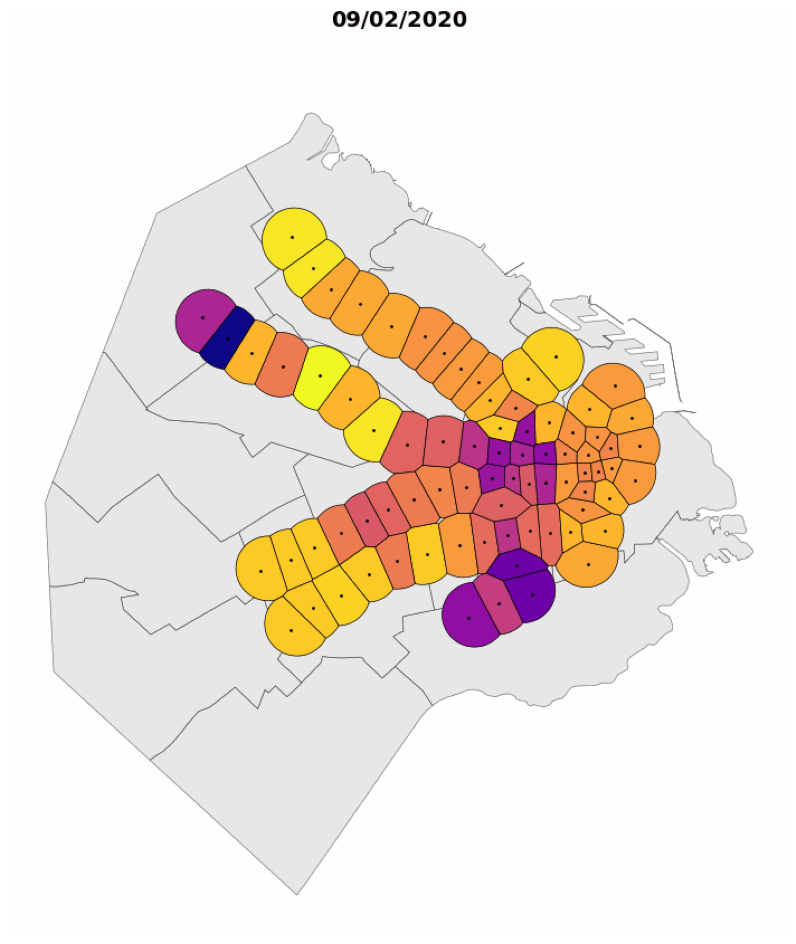

In [45]:
from PIL import Image
import imageio.v2 as imageio
import matplotlib.pyplot as plt

def display_gif_frame(gif_path, percentage):
    """
    Extracts and displays a frame at a given percentage of the GIF's animation.
    
    Parameters:
    - gif_path: Path to the GIF file.
    - percentage: Float (0 to 100) indicating how far through the animation to extract the frame.
    """
    gif = Image.open(gif_path)
    num_frames = gif.n_frames
    frame_index = int((percentage / 100) * (num_frames - 1))

    gif.seek(frame_index)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(gif)
    plt.axis("off")
    plt.show()

# Example usage:
display_gif_frame("buenos_aires_voronoi_disease.gif", 54.1)  # Display frame at 40% of animation


In [288]:
home_betas

array([0.10117694, 0.23119958, 0.2864381 , 0.16996024, 0.23171692,
       0.12034237, 0.31447598, 0.21022664, 0.32141642, 0.23419201,
       0.28395379, 0.13791398, 0.25049037, 0.22203202, 0.35144658,
       0.21542986, 0.18265557, 0.10309837, 0.17068221, 0.5183465 ,
       0.22070179, 0.34279346, 0.24171347, 0.27897019, 0.33675797,
       0.38050764, 0.25533446, 0.20161339, 0.31528532, 0.33599492,
       0.16295571, 0.14144599, 0.20360139, 0.25653894, 0.57461039,
       0.2954388 , 0.18271849, 0.26419115, 0.28406071, 0.43295378,
       0.19751055, 0.34803052, 0.28002877, 0.15535991, 0.17219888,
       0.22534003, 0.26272932, 0.28291427, 0.23753499, 0.15303264,
       0.28049773, 0.25832752, 0.2115037 , 0.35040458, 0.19046883,
       0.19158871, 0.26691736, 0.14585483, 0.31396563, 0.30377715,
       0.22012034, 0.28999218, 0.28644836, 0.30058061, 0.25897012,
       0.33574435, 0.17291314, 0.23609446, 0.55862036, 0.38936966,
       0.79995846, 0.35768237, 0.52002698, 0.54160412, 0.42065

In [362]:
home_betas

array([0.10005806, 0.        , 0.        , 0.        , 0.        ,
       0.1988816 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1988816 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1988816 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1988816 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1988816 , 0.     

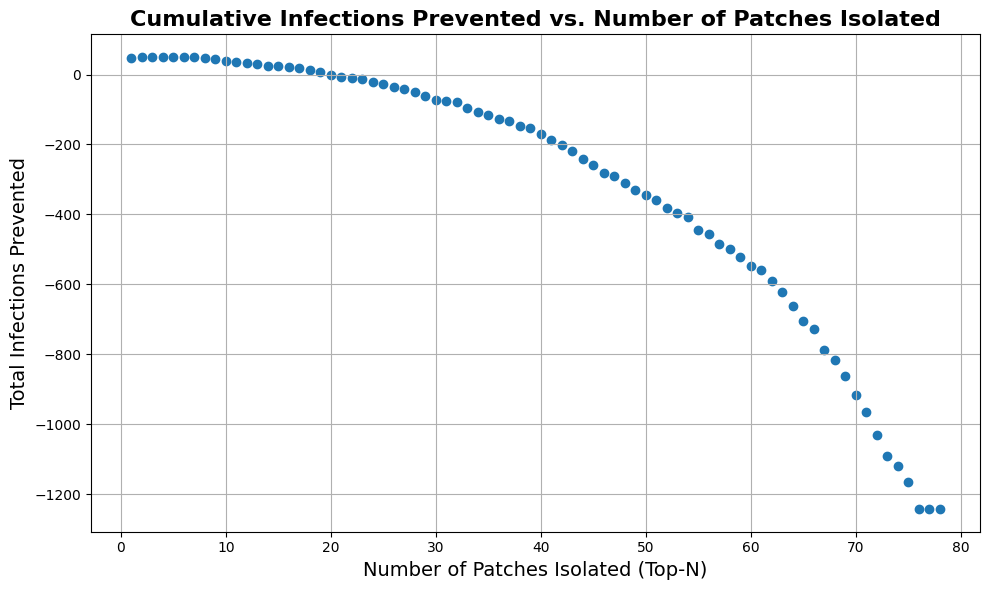

In [67]:
total_infections_prevented = np.array([np.float64(47.98293769476004),
 np.float64(49.265792805701494),
 np.float64(49.02737052773591),
 np.float64(49.253596516908146),
 np.float64(49.95857214019634),
 np.float64(50.24070498882793),
 np.float64(49.54619859927334),
 np.float64(47.1560293949442),
 np.float64(43.209548779414035),
 np.float64(38.8915991949616),
 np.float64(36.39789073576685),
 np.float64(33.22957176272757),
 np.float64(30.687397670699283),
 np.float64(25.000162129639648),
 np.float64(23.513274605036713),
 np.float64(22.550132491160184),
 np.float64(18.277329100179486),
 np.float64(13.493463356979191),
 np.float64(7.850800436805002),
 np.float64(0.020142408786341548),
 np.float64(-7.397328917519189),
 np.float64(-10.517328942310996),
 np.float64(-12.525593558326364),
 np.float64(-20.764646580792032),
 np.float64(-27.45973102399148),
 np.float64(-36.77609008853324),
 np.float64(-39.9705067431787),
 np.float64(-49.85672524292022),
 np.float64(-60.68072756566107),
 np.float64(-72.50478225201368),
 np.float64(-74.52821564034093),
 np.float64(-79.1393610277446),
 np.float64(-96.09844908583909),
 np.float64(-107.87684585992247),
 np.float64(-117.03217030118685),
 np.float64(-126.13500364474021),
 np.float64(-134.1947810279671),
 np.float64(-145.95436097343918),
 np.float64(-152.1654771643225),
 np.float64(-171.0075013069436),
 np.float64(-187.97127312910743),
 np.float64(-200.9752248665318),
 np.float64(-219.57237330835778),
 np.float64(-242.3529610215919),
 np.float64(-259.7625480298884),
 np.float64(-280.07451996335294),
 np.float64(-291.349702915526),
 np.float64(-308.73293590487447),
 np.float64(-331.2353101465851),
 np.float64(-344.6883616904961),
 np.float64(-357.5649654279696),
 np.float64(-382.41560482711066),
 np.float64(-396.15369375701994),
 np.float64(-408.0543996086344),
 np.float64(-443.6084768984001),
 np.float64(-456.49999086686876),
 np.float64(-483.5306051605148),
 np.float64(-497.3576276113745),
 np.float64(-522.0306708101416),
 np.float64(-546.9713631710038),
 np.float64(-558.7477262704633),
 np.float64(-591.3031023604563),
 np.float64(-621.3669886033749),
 np.float64(-661.487283681985),
 np.float64(-703.773605272756),
 np.float64(-727.0867005346809),
 np.float64(-787.5046412521042),
 np.float64(-817.2862091915449),
 np.float64(-862.5562260890147),
 np.float64(-915.0462326509878),
 np.float64(-965.8121622659964),
 np.float64(-1029.369671115186),
 np.float64(-1090.1701457418967),
 np.float64(-1117.9961953472812),
 np.float64(-1165.3113374595996),
 np.float64(-1242.073477330734),
 np.float64(-1242.1127973265247),
 np.float64(-1242.1127973265247)])

import matplotlib.pyplot as plt

x_vals = np.arange(1, len(total_infections_prevented)+ 1)

plt.figure(figsize=(10,6))
plt.scatter(x_vals, total_infections_prevented, marker='o')
plt.xlabel('Number of Patches Isolated (Top-N)', fontsize=14)
plt.ylabel('Total Infections Prevented', fontsize=14)
plt.title('Cumulative Infections Prevented vs. Number of Patches Isolated', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

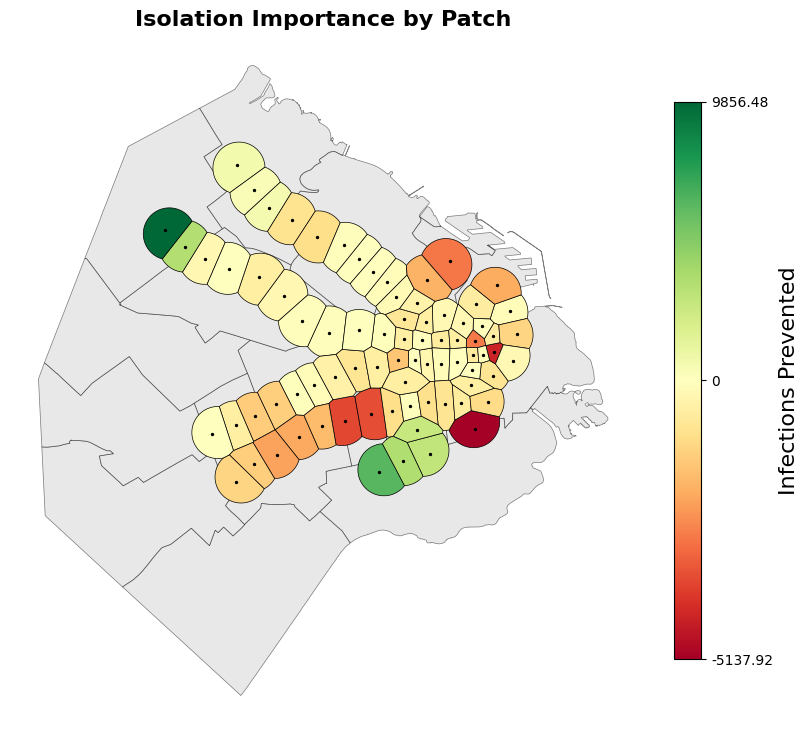

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import numpy as np

with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

def plot_isolation_effects_map(patch_isolation_effects, title="Isolation Importance by Patch"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    voronoi_gdf["effects"] = patch_isolation_effects

    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    vmin = voronoi_gdf["effects"].min()
    vmax = voronoi_gdf["effects"].max()
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

    mesh = voronoi_gdf.plot(
        ax=ax,
        column="effects",
        cmap="RdYlGn",
        norm=norm,
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
        legend=False  # don't use built-in legend
    )

    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
    sm.set_array([])  # needed for colorbar
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04, ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels([f"{vmin:.2f}", "0", f"{vmax:.2f}"])
    cbar.set_label("Infections Prevented", fontsize=16)

    voronoi_gdf["geometry"].centroid.plot(ax=ax, color="black", markersize=2)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.show()

plot_isolation_effects_map(patch_isolation_effects)


In [59]:
with open("Fixed Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    p_populations = pickle.load(file)

p_populations *= np.sum(short_pop_vector)/np.sum(p_populations)

people_affected_by_isolation = []

for home in range(78):
    #home people going to work
    people = np.sum(p_populations[home])-p_populations[home][home]
    
    #people coming to work in home
    people += np.sum(p_populations.T[home])-p_populations[home][home]
    
    people_affected_by_isolation.append(people)
    
people_affected_by_isolation

[np.float64(70030.03946293321),
 np.float64(24336.090095014642),
 np.float64(27133.274113395437),
 np.float64(10495.42179161547),
 np.float64(31669.38542059716),
 np.float64(27906.289201613105),
 np.float64(12248.890915401904),
 np.float64(8819.550084873274),
 np.float64(11522.652938805717),
 np.float64(25546.614549376223),
 np.float64(31850.96097602519),
 np.float64(33959.6139108809),
 np.float64(22941.706432796942),
 np.float64(38271.098717589586),
 np.float64(14968.346071403615),
 np.float64(16730.16293612578),
 np.float64(10444.632394156943),
 np.float64(92920.56600186732),
 np.float64(28736.338352186754),
 np.float64(72518.51432763439),
 np.float64(191456.44939000777),
 np.float64(16034.246849838111),
 np.float64(39007.098185507406),
 np.float64(20361.164113343853),
 np.float64(23197.777135628017),
 np.float64(13315.047624417155),
 np.float64(10006.99101017628),
 np.float64(9082.178466282565),
 np.float64(61622.36145733329),
 np.float64(15598.089416082166),
 np.float64(39324.48350

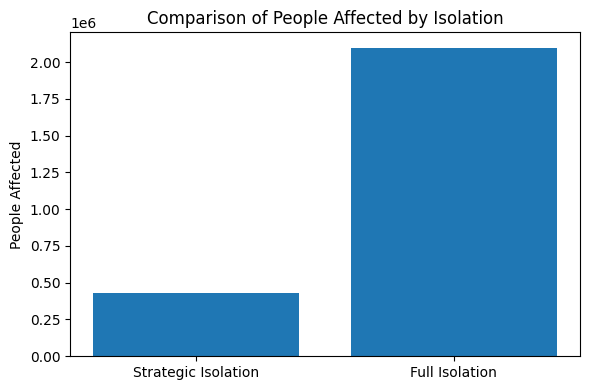

In [61]:
people_affected_by_isolation = np.array(people_affected_by_isolation)

best_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation[np.array([ 3, 40, 51, 50, 28, 62, 54,  1, 48,  4, 45, 65, 15, 56, 77, 27, 63,
       39, 33, 38,  8])])

full_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation)

# Values
values = [best_iso_affected_ppl, full_iso_affected_ppl]
labels = ['Strategic Isolation', 'Full Isolation']

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel('People Affected')
plt.title('Comparison of People Affected by Isolation')
plt.tight_layout()
plt.show()

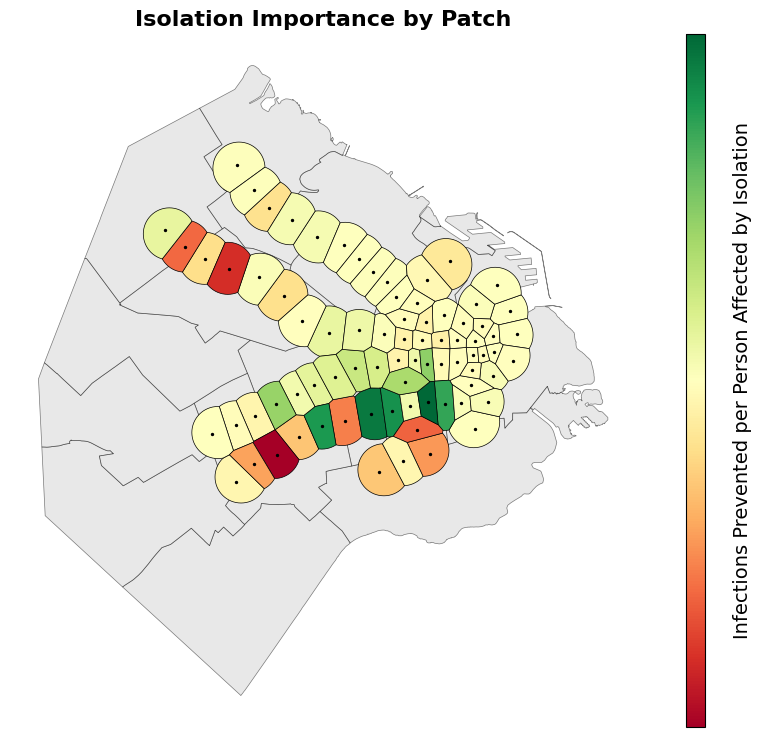

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import numpy as np
import pickle

with open("14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

def plot_isolation_effects_map(patch_isolation_effects, title="Isolation Importance by Patch"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    effects = np.array(patch_isolation_effects) / (0.9*np.array(people_affected_by_isolation))
    voronoi_gdf["effects"] = effects

    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5)

    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=voronoi_gdf["effects"].min(), vmax=voronoi_gdf["effects"].max())
    im = voronoi_gdf.plot(
        ax=ax,
        column="effects",
        cmap="RdYlGn",
        norm=norm,
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
        legend=True,
        cax=cax
    )

    cax.set_yticks([])  # remove ticks/numbers
    cax.yaxis.set_label_position('right')
    cax.yaxis.set_label_coords(2.5, 0.5)
    cax.set_ylabel("Infections Prevented per Person Affected by Isolation", fontsize=14)

    voronoi_gdf["geometry"].centroid.plot(ax=ax, color="black", markersize=2)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.show()

plot_isolation_effects_map(patch_isolation_effects)


In [45]:
best_top_n = np.argmax(infection_sums) + 1  # +1 because x_vals starts at 1

# Now, get the top-N values from patch_isolation_effects
top_n_values = np.sort(patch_isolation_effects)[-best_top_n:]  # largest N values


top_n_indices = np.argsort(patch_isolation_effects)[-best_top_n:]
top_n_values = patch_isolation_effects[top_n_indices]

In [48]:
np.array(station_list)[top_n_indices]

array(['ALBERTI', 'JUJUY', 'OLLEROS', 'MTRO CARRANZA MIGUEL ABUELO',
       'F. LACROZE', 'PRIMERA JUNTA', 'PASCO', 'ACOYTE',
       'MEDRANO ALMAGRO', 'ANGEL GALLARDO', 'LORIA', 'RIO DE JANEIRO',
       'CASTRO BARROS', 'PICHINCHA', 'VENEZUELA',
       'ENTRE RIOS RODOLFO WALSH', 'PUAN',
       'JUAN MANUEL DE ROSAS VILLA URQUIZA', 'GRAL. URQUIZA',
       'JOSE MARIA MORENO', 'BOEDO'], dtype='<U35')

In [49]:
top_n_indices

array([ 3, 40, 51, 50, 28, 62, 54,  1, 48,  4, 45, 65, 15, 56, 77, 27, 63,
       39, 33, 38,  8])

In [63]:
N = pop_vector.copy()
gamma = 1/5

def calc_F_for_idx(i):
    F = 0
    
    for k in range(78):
        p_k = home_patches[k]
        denom = 0
        for l in range(78):
            p_l = home_patches[l]
            denom += p_matrix[p_l][p_k]
        F += home_betas[k]*p_matrix[i][p_k]*p_matrix[i][p_k]/denom
    
    return F

calc_F_for_idx(0)

patch_Fs = []
for i in range(78):
    patch_Fs.append(calc_F_for_idx(home_patches[i]))
patch_Fs = np.array(patch_Fs)
patch_Fs

gamma = 1/5

patch_R0s = patch_Fs/gamma
patch_R0s

array([0.30484064, 0.67269841, 0.71669321, 0.71397636, 0.63867369,
       0.57533484, 0.90432912, 0.84806593, 0.78970077, 0.70296743,
       0.69106927, 0.47221471, 0.78574332, 0.54304126, 1.07412655,
       0.73795365, 0.8170694 , 0.24260265, 0.56599077, 0.60679328,
       0.21233274, 0.81577851, 0.46947525, 0.8718967 , 0.85753064,
       1.11413002, 0.89335147, 0.75760229, 0.51044519, 0.85885805,
       0.46259637, 0.57931811, 0.83765751, 0.75983867, 0.94813373,
       1.08960965, 0.54142562, 0.8625811 , 0.76833619, 0.82168754,
       0.65500244, 0.71608209, 0.80247873, 0.74303645, 0.42482485,
       0.72066866, 0.70739242, 0.93864764, 0.60936545, 0.78862207,
       0.70405014, 0.70818829, 0.54535453, 1.00997676, 0.76462948,
       0.59577958, 0.77370393, 0.7592592 , 0.79236232, 0.58930394,
       0.64227454, 0.3250127 , 0.61620649, 0.73639542, 0.34184835,
       0.68495228, 0.74802247, 0.85415524, 0.73683084, 0.83150604,
       0.52551068, 0.52309547, 0.67710373, 0.64787974, 0.96033

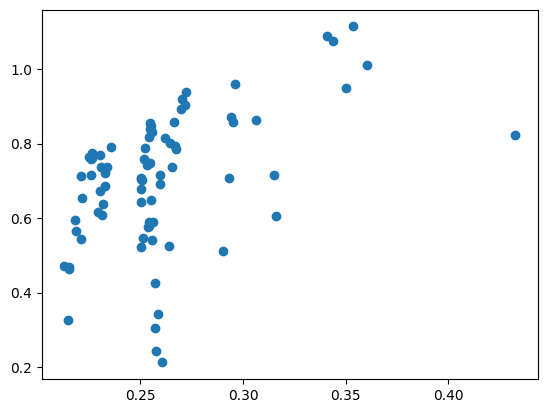

In [64]:
plt.scatter(home_betas,patch_R0s)

In [22]:
patch_isolation_effects/short_pop_vector

array([-4.91460398, -0.02306657, -0.01057921, -0.00574007, -0.01823239,
       -1.82617724,  0.00822555, -0.02084582, -0.0405866 , -0.01250641,
       -0.01017956, -0.49246553, -0.01108917,  0.0201661 ,  0.13280363,
       -0.03399586, -0.01846397, -6.47123895,  0.00406494,  0.02204032,
       -1.29959821, -0.01451716, -0.21559864,  0.02671036,  0.02689789,
        0.16525752,  0.0023496 , -0.03923573, -0.0854573 , -0.00629121,
       -0.24888541, -0.81635978, -0.0221998 , -0.03975659,  0.13295164,
        0.13551306, -0.24949412,  0.04137873, -0.04131368,  0.12967037,
        0.00203049,  0.02334546, -0.01163578, -0.02075451, -0.67910864,
       -0.03058689,  0.01051407,  0.01009993, -0.01296027, -0.00512742,
       -0.02180882, -0.02181585,  0.00286722,  0.11386727, -0.03481404,
        0.00419865, -0.04018046, -0.10239563, -0.01372073, -0.0276025 ,
        0.0023249 , -0.74830647, -0.00866487, -0.03958065, -1.06982754,
       -0.02812602, -0.00226087, -0.02175944, -0.01338255, -0.02

In [57]:
# Build adjacency matrix
station_names = list(station_geom.keys())
name_to_idx = {name: idx for idx, name in enumerate(station_names)}
n = len(station_names)

adj_matrix = np.zeros((n, n))
for s1, s2 in selected_pairs:
    if s1 in name_to_idx and s2 in name_to_idx:
        i, j = name_to_idx[s1], name_to_idx[s2]
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  # undirected

# Degree
degrees = adj_matrix.sum(axis=1)

# Correlate degree vs isolation effect
from scipy.stats import spearmanr
spearmanr(degrees, patch_isolation_effects)


SignificanceResult(statistic=np.float64(-0.06101217621013276), pvalue=np.float64(0.5956682649664495))

In [32]:
degrees.shape
np.array(patch_isolation_effects).shape

(78,)

/tmp/ipykernel_2071547/1179456594.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_effects, labels=degree_bins, showfliers=False)


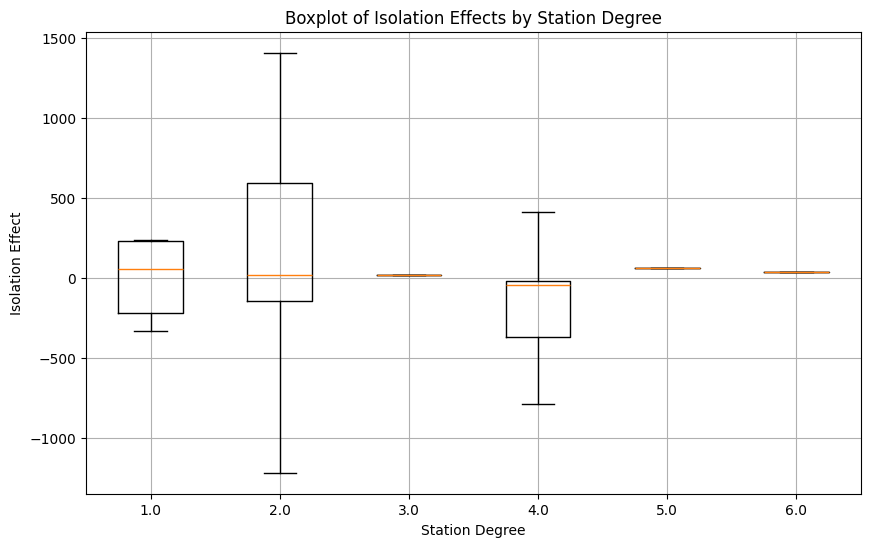

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Bin degrees
degree_bins = np.unique(degrees)  # unique degree values

patch_isolation_effects = np.array(patch_isolation_effects)

# Group isolation effects by degree
grouped_effects = [patch_isolation_effects[(degrees == d)] for d in degree_bins]


# Boxplot
plt.figure(figsize=(10,6))
plt.boxplot(grouped_effects, labels=degree_bins, showfliers=False)
plt.xlabel("Station Degree")
plt.ylabel("Isolation Effect")
plt.title("Boxplot of Isolation Effects by Station Degree")
plt.grid(True)
plt.show()


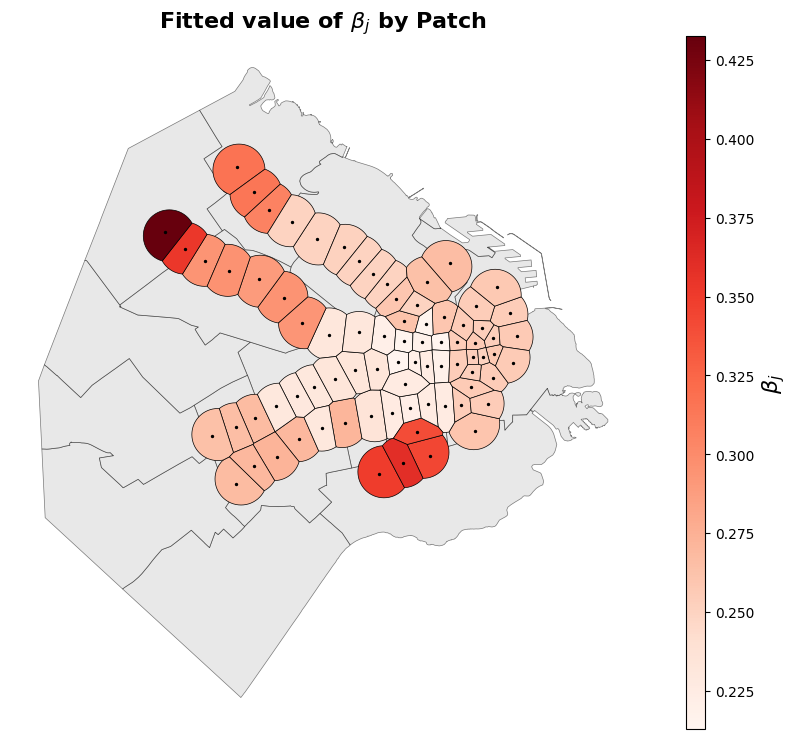

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

home_betas = best_beta_yet[:78]
home_betas.shape

import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

home_betas = best_beta_yet[:78]
home_betas.shape

def plot_beta_map(beta_array, title="Fitted value of $\\beta_j$ by Patch"):
    """
    Plots Voronoi patches of Buenos Aires colored by beta values,
    with boroughs in the background, station dots, and a shortened colorbar.
    """
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS match
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add beta values
    voronoi_gdf["beta"] = beta_array

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    # Colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5)

    # Plot Voronoi with colorbar
    im = voronoi_gdf.plot(
        ax=ax,
        column="beta",
        cmap="Reds",
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
        legend=True,
        cax=cax
    )

    cax.set_ylabel(r"$\beta_j$", fontsize=16)

    # Add station dots
    voronoi_gdf["centroid"] = voronoi_gdf.geometry.centroid
    voronoi_gdf["centroid"].plot(ax=ax, color="black", markersize=2)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.show()




plot_beta_map(home_betas)

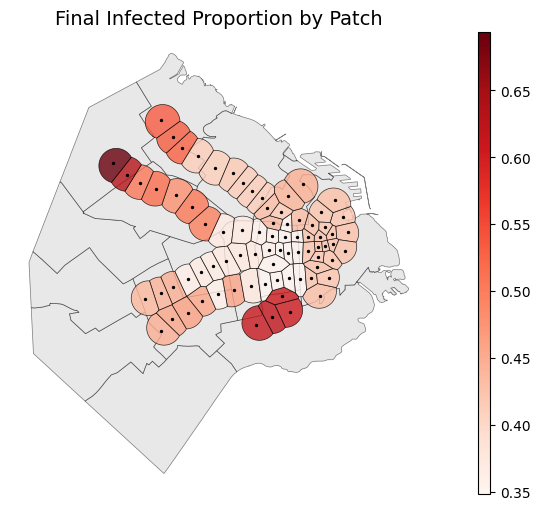

In [47]:
final_infected = solution[2][home_patches].T[-1]
final_infected_prop = final_infected/short_pop_vector
final_infected_prop

def plot_inf_map(final_infected_prop, title="Final Infected Proportion by Patch"):
    """
    Plots Voronoi patches of Buenos Aires colored by final infected proportion,
    with boroughs in the background, station dots, and a shortened colorbar.
    """
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS match
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add infected proportion values
    voronoi_gdf["inf_prop"] = final_infected_prop

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    # Colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5)

    # Plot Voronoi with colorbar
    voronoi_gdf.plot(
        ax=ax,
        column="inf_prop",
        cmap="Reds",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        legend=True,
        cax=cax
    )

    # Add station dots
    voronoi_gdf["centroid"] = voronoi_gdf.geometry.centroid
    voronoi_gdf["centroid"].plot(ax=ax, color="black", markersize=2)

    # Final touches
    ax.set_title(title, fontsize=14)
    ax.axis("off")
    plt.show()

plot_inf_map(final_infected_prop)


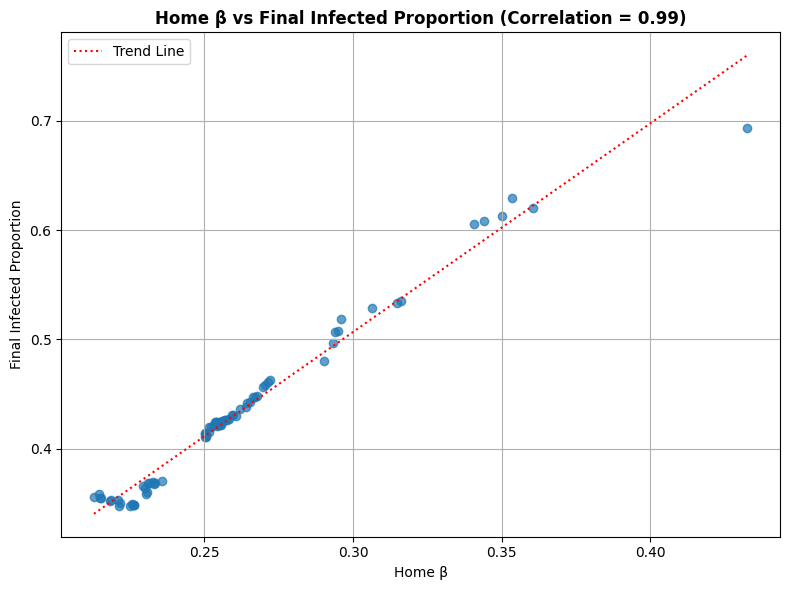

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation
corr = np.corrcoef(home_betas, final_infected_prop)[0, 1]

# Compute residuals (difference from regression line)
residuals = final_infected_prop - np.poly1d(np.polyfit(home_betas, final_infected_prop, 1))(home_betas)

# Get indices of 5 largest absolute residuals (outliers)
outlier_indices = np.argsort(np.abs(residuals))[-1:]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(home_betas, final_infected_prop, alpha=0.7)



# Fit and plot dotted trend line
m, b = np.polyfit(home_betas, final_infected_prop, 1)
x_vals = np.array([min(home_betas), max(home_betas)])
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, linestyle=':', color='red', label='Trend Line')
plt.legend()

plt.title(f"Home β vs Final Infected Proportion (Correlation = {corr:.2f})", fontweight='bold')
plt.xlabel("Home β")
plt.ylabel("Final Infected Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


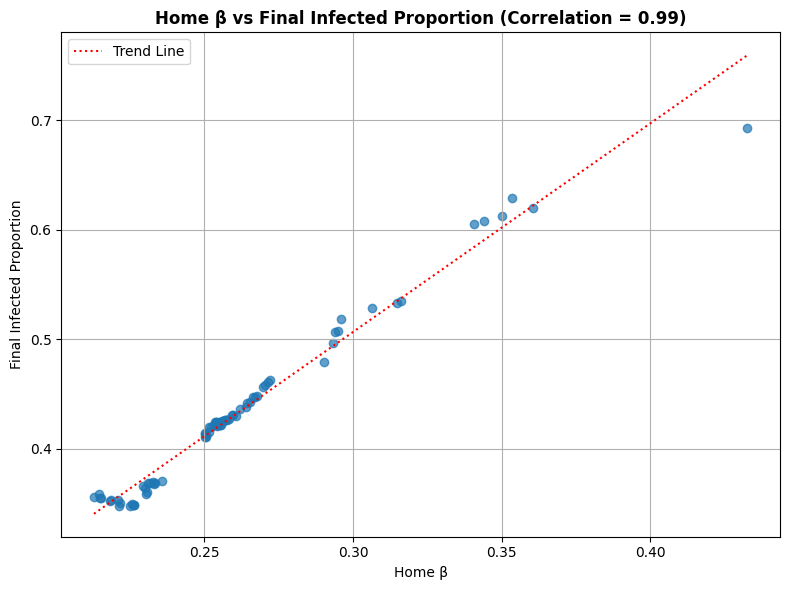

In [394]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation
corr = np.corrcoef(home_betas, final_infected_prop)[0, 1]

# Compute residuals (difference from regression line)
residuals = final_infected_prop - np.poly1d(np.polyfit(home_betas, final_infected_prop, 1))(home_betas)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(home_betas, final_infected_prop, alpha=0.7)


# Fit and plot dotted trend line
m, b = np.polyfit(home_betas, final_infected_prop, 1)
x_vals = np.array([min(home_betas), max(home_betas)])
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, linestyle=':', color='red', label='Trend Line')
plt.legend()

plt.title(f"Home β vs Final Infected Proportion (Correlation = {corr:.2f})", fontweight='bold')
plt.xlabel("Home β")
plt.ylabel("Final Infected Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


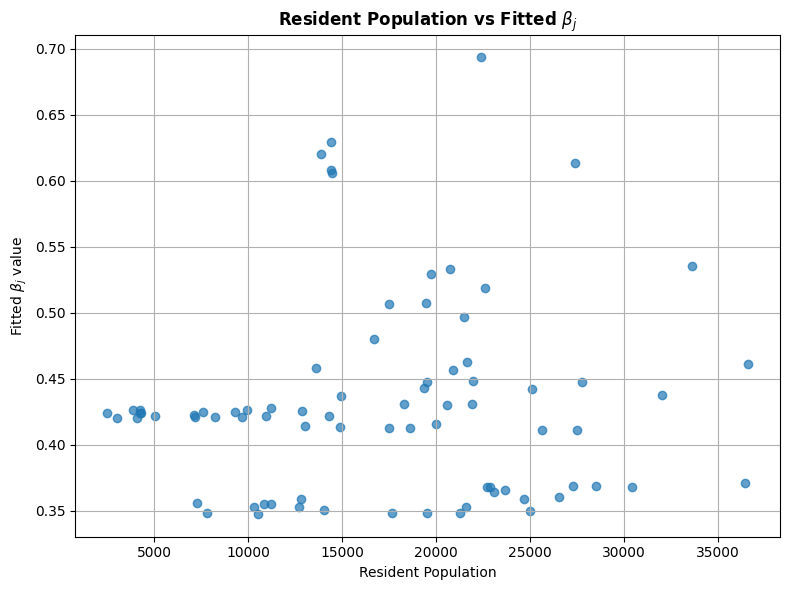

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(short_pop_vector, final_infected_prop, alpha=0.7)




plt.title(f"Resident Population vs Fitted $\\beta_j$",fontweight='bold')
plt.xlabel("Resident Population")
plt.ylabel("Fitted $\\beta_j$ value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
Nj.shape

(6084,)

In [69]:
toy_station_list = ["A","B"]
toy_p_matrix = np.array([
    [0.5,0.1,0.1,0.3],
    [0,1,0,0],
    [0,0,1,0],
    [0.25,0.1,0.1,0.55]
])

toy_home_patches = [0,3]
toy_pop_vector = np.array([100,0,0,1000])
toy_Nj = toy_pop_vector @ toy_p_matrix
print("Toy Nj:",toy_Nj)
toy_short_pop_vector = np.array([100,1000])

toy_commuter_vs_residents = np.zeros(2)

for i in range(2):
    home_patch = toy_station_list[i]
    home_idx = toy_home_patches[i]
    
    effective_residents = toy_p_matrix[home_idx][home_idx]*toy_short_pop_vector[i]
    effective_commuters = toy_Nj[home_idx]-effective_residents
    toy_commuter_vs_residents[i] = effective_commuters/effective_residents
    print(effective_residents,effective_commuters)

Toy Nj: [300. 110. 110. 580.]
50.0 250.0
550.0 30.0


In [71]:
toy_commuter_vs_residents

array([5.        , 0.05454545])

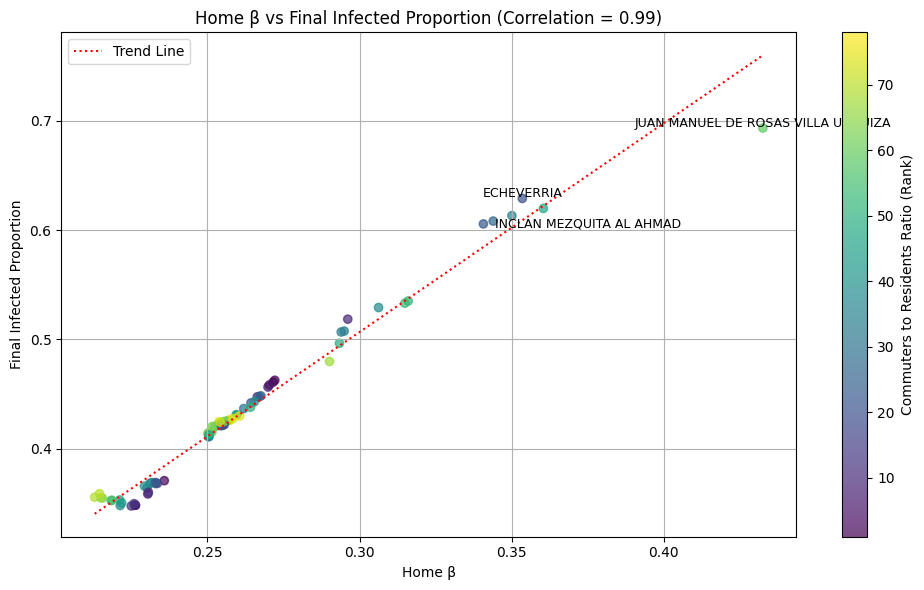

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata

commuters_vs_residents = Nj[home_patches]/short_pop_vector
commuters_vs_residents

# Compute correlation
corr = np.corrcoef(home_betas, final_infected_prop)[0, 1]

# Compute residuals
residuals = final_infected_prop - np.poly1d(np.polyfit(home_betas, final_infected_prop, 1))(home_betas)

# Get indices of 8 largest absolute residuals
outlier_indices = np.argsort(np.abs(residuals))[-3:]

# Rank commuters_vs_residents
ranks = rankdata(commuters_vs_residents, method='average')

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    home_betas, final_infected_prop,
    c=ranks, cmap='viridis', alpha=0.7
)

for i, idx in enumerate(outlier_indices):
    if i % 2 == 0:
        offset = (0, 8)
        ha, va = 'center', 'top'
    else:
        offset = (8, 0)
        ha, va = 'left', 'center'
    
    plt.annotate(
        station_list[idx],
        (home_betas[idx], final_infected_prop[idx]),
        fontsize=9,
        xytext=offset,
        textcoords='offset points',
        ha=ha,
        va=va
    )

# Fit and plot trend line
m, b = np.polyfit(home_betas, final_infected_prop, 1)
x_vals = np.array([min(home_betas), max(home_betas)])
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, linestyle=':', color='red', label='Trend Line')

# Colorbar with rank ticks
cbar = plt.colorbar(scatter, label='Commuters to Residents Ratio (Rank)')

plt.legend()
plt.title(f"Home β vs Final Infected Proportion (Correlation = {corr:.2f})")
plt.xlabel("Home β")
plt.ylabel("Final Infected Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
for i in range(78):
    if np.sum(p_populations[i]) == 0:
        print(i)

8
9
12
16
18
19
20
26
31
34
35
47
48
50
51
55
59
63
65
66
67
72
74
77


In [72]:
p_populations

array([[4021.,  219.,  612., ...,  314.,  132.,    0.],
       [ 389., 2356.,  107., ...,  330.,   42.,    0.],
       [ 569.,   88., 1727., ...,  461.,   64.,    0.],
       ...,
       [ 311.,  162.,  497., ..., 2899.,  112.,    0.],
       [ 219.,   53.,  147., ...,  200., 1455.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [80]:
with open("Fixed Final Commuter Matrix Buenos Aires.pkl",'rb') as file:
    p_populations = pickle.load(file)
    
commuters_vs_residents = []
for i in range(78):
    residents = np.sum(p_populations[i])
    col_sum = np.sum(p_populations.T[i])
    commuters = col_sum - p_populations[i][i]
    commuters_vs_residents.append(commuters/residents)
commuters_vs_residents = np.array(commuters_vs_residents)
commuters_vs_residents

array([3.10834298, 0.57964603, 0.72214004, 1.5376616 , 0.47603667,
       4.61341836, 0.37321284, 1.12867315, 0.3748522 , 0.75438254,
       0.61005364, 1.70430026, 0.60881465, 0.6176986 , 0.88596835,
       0.58533842, 1.66301618, 2.86280525, 1.01303685, 0.40361496,
       0.64532298, 0.8584708 , 1.14270074, 0.74978695, 0.68087108,
       0.88578386, 0.62526455, 0.66668612, 0.78688429, 0.48465217,
       1.17614609, 2.77407272, 1.26281943, 0.61544179, 0.49386099,
       0.88205773, 1.3595879 , 0.67381148, 0.53679734, 0.59640859,
       0.92033741, 0.6424942 , 0.53607193, 2.30035546, 1.27684645,
       0.5839016 , 0.62162018, 0.6068452 , 0.44676204, 2.77088358,
       0.49302233, 0.52641346, 0.66449836, 0.93360043, 1.16539439,
       1.22566907, 0.72996906, 3.66745786, 0.67769407, 1.0051905 ,
       0.87683067, 1.01092033, 0.56719615, 0.50590353, 1.1420557 ,
       0.49644782, 1.68769864, 1.46214701, 0.68558337, 0.88907423,
       0.42352241, 0.99333544, 0.7119835 , 1.63431131, 0.58542

In [ ]:
commuters_vs_residents = np.zeros(78)

for i in range(78):
    home_patch = station_list[i]
    home_idx = home_patches[i]
    
    effective_residents = p_matrix[home_idx][home_idx]*short_pop_vector[i]
    effective_commuters = Nj[home_idx]-effective_residents
    commuters_vs_residents[i] = effective_commuters/effective_residents
    
commuters_vs_residents


=== Ratio Summary BEFORE Transformation ===
Min: 0.3732, Max: 4.6134, Mean: 1.0548, Median: 0.7399
Top 10 values: [4.61341836 3.66745786 3.10834298 2.86280525 2.81921518 2.77407272
 2.77088358 2.30035546 1.70430026 1.68769864]

=== Ratio Summary AFTER Log base-10 Transformation ===
Min: -0.4280, Max: 0.6640, Mean: -0.0583, Median: -0.1309
Top 10 transformed values: [0.66402284 0.56436513 0.49252893 0.45679181 0.45012823 0.44311784
 0.44261828 0.36179495 0.23154611 0.2272949 ]


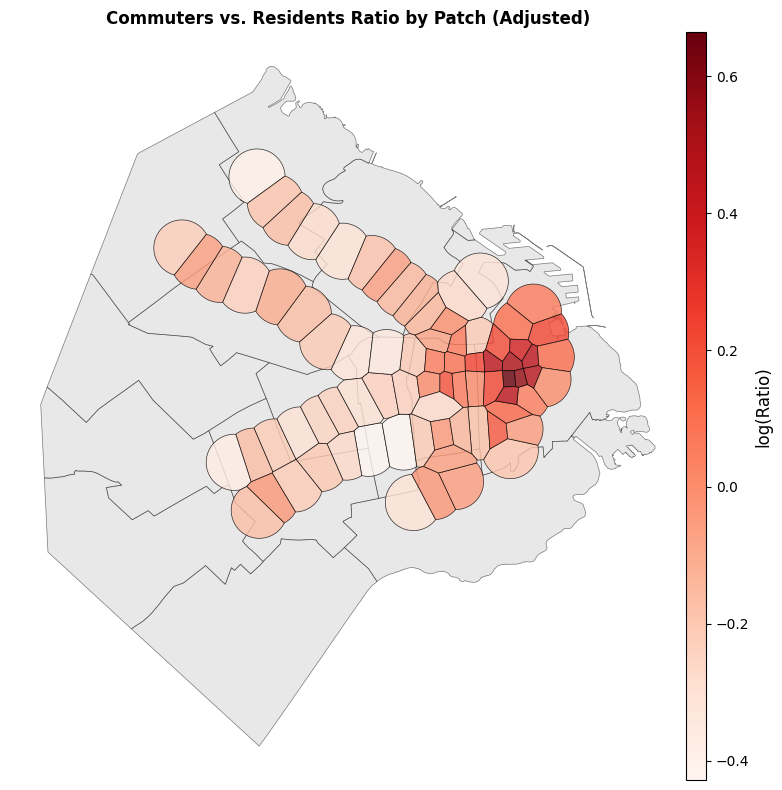

In [88]:
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.colors import LogNorm

def plot_ratio_map_ba(ratio, title="Commuters vs. Residents Ratio by Patch (Adjusted)", log_base=1):
    """
    Plots Voronoi patches of Buenos Aires colored by actual ratio values,
    with boroughs in the background and an adjustable colorbar scale.
    """
    # Load data
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS match
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Print summary before transformation
    print("=== Ratio Summary BEFORE Transformation ===")
    print(f"Min: {np.min(ratio):.4f}, Max: {np.max(ratio):.4f}, Mean: {np.mean(ratio):.4f}, Median: {np.median(ratio):.4f}")
    print("Top 10 values:", np.sort(ratio)[-10:][::-1])

    # Log transformation
    if log_base > 1:
        ratio = np.log(np.clip(ratio, 1e-6, None)) / np.log(log_base)
        norm = None
        label = f"log(Ratio)"
        print(f"\n=== Ratio Summary AFTER Log base-{log_base} Transformation ===")
        print(f"Min: {np.min(ratio):.4f}, Max: {np.max(ratio):.4f}, Mean: {np.mean(ratio):.4f}, Median: {np.median(ratio):.4f}")
        print("Top 10 transformed values:", np.sort(ratio)[-10:][::-1])
    elif log_base == 1:
        ratio = np.clip(ratio, 1e-6, None)
        norm = LogNorm(vmin=ratio.min(), vmax=ratio.max())
        label = "Log-Normalized Ratio"
    else:
        norm = None
        label = "Commuter-to-Resident Ratio"

    voronoi_gdf["ratio"] = ratio

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 8))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    # Colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=-0)

    # Plot Voronoi
    cmap = plt.cm.Reds
    voronoi_gdf.plot(
        ax=ax,
        column="ratio",
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        norm=norm
    )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm or plt.Normalize(vmin=ratio.min(), vmax=ratio.max()))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(label, fontsize=12)

    ax.set_title(title, fontweight='bold')
    ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_ratio_map_ba(commuters_vs_residents, log_base=10)


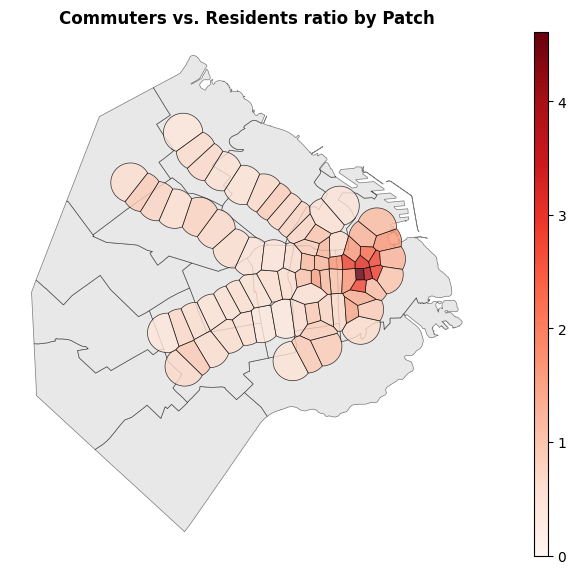

In [89]:
def plot_raw_ratio_map_ba(ratio, title="Commuters vs. Residents ratio by Patch"):
    """
    Plots Voronoi patches of Buenos Aires colored by raw ratio values,
    with boroughs in the background and an adjusted colorbar.
    """
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS match
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add raw ratio values
    voronoi_gdf["raw_ratio"] = ratio

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    # Colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5)

    vmin = 0  # or np.min(commuters_vs_residents)
    vmax = np.max(ratio)

    # In both plot functions, add vmin=vmin, vmax=vmax to voronoi_gdf.plot:
    voronoi_gdf.plot(
        ax=ax,
        column="raw_ratio",
        cmap="Reds",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        legend=True,
        cax=cax,
        vmin=vmin,
        vmax=vmax
    )

    # Final touches
    ax.set_title(title, fontweight='bold')
    ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_raw_ratio_map_ba(commuters_vs_residents)


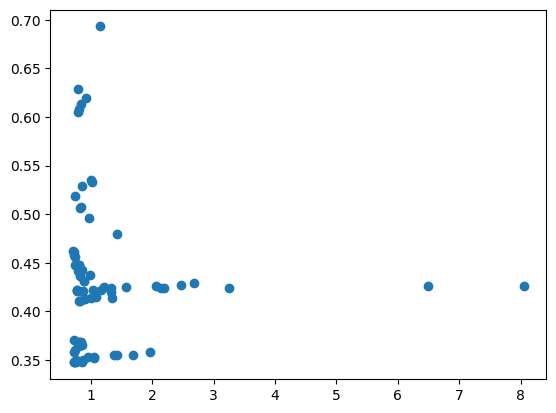

In [383]:
plt.scatter(commuters_vs_residents,final_infected_prop)

In [53]:
def create_patch_focus_gif_ba(p_matrix, home_patches, station_list, label="Patch"):
    output_filename = "patch_focus_voronoi_ba.gif"
    
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure projected CRS
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Sort patches left to right by x-coordinate
    metric_voronoi = voronoi_gdf.to_crs(epsg=3857)
    metric_voronoi["x"] = metric_voronoi.geometry.centroid.x
    sorted_indices = metric_voronoi.sort_values("x").index.tolist()

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for i, gdf_idx in enumerate(tqdm(sorted_indices, desc="Generating Patch Focus Frames")):
            true_idx = home_patches[gdf_idx]
            row_vals = p_matrix[true_idx, home_patches]
            row_vals[gdf_idx] = np.nan  # exclude self

            if np.all(np.isnan(row_vals)):
                norm_vals = np.full(len(home_patches), 0.5)
            else:
                masked_vals = np.where(np.isnan(row_vals), np.nan, row_vals)
                max_val = np.nanmax(masked_vals)
                norm_vals = row_vals / max_val if max_val > 0 else np.zeros_like(row_vals)

            voronoi_gdf["color"] = norm_vals

            # Focus patch in green
            base_colors = plt.cm.plasma(voronoi_gdf["color"].fillna(0))
            base_colors[gdf_idx] = (0, 1, 0, 1)  # green
            voronoi_gdf["custom_color"] = list(base_colors)

            fig, ax = plt.subplots(figsize=(6, 6))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(ax=ax, color=voronoi_gdf["custom_color"], edgecolor="black", linewidth=0.5, alpha=1)
            
            # Plot station centroids
            voronoi_gdf["centroid"] = voronoi_gdf.geometry.centroid
            voronoi_gdf["centroid"].plot(ax=ax, color="black", markersize=1)

            ax.text(0.5, 1.01, f"{label}: {station_list[gdf_idx].title()}", transform=ax.transAxes,
                    fontsize=12, ha="center", va="bottom", fontweight="bold")
            ax.set_axis_off()
            plt.tight_layout(pad=0)

            temp_path = os.path.join(temp_dir, f"frame_{i}.png")
            plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            frames.append(imageio.imread(temp_path))

        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=1.5, loop=0)
        IPython.display.clear_output(wait=True)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


create_patch_focus_gif_ba(p_matrix, home_patches, station_list)


In [60]:
# Making it transparent

def create_patch_focus_gif_ba(p_matrix, home_patches, station_list, label="Patch"):
    output_filename = "patch_focus_voronoi_ba.gif"
    
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure projected CRS
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Sort patches left to right by x-coordinate
    metric_voronoi = voronoi_gdf.to_crs(epsg=3857)
    metric_voronoi["x"] = metric_voronoi.geometry.centroid.x
    sorted_indices = metric_voronoi.sort_values("x").index.tolist()

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for i, gdf_idx in enumerate(tqdm(sorted_indices, desc="Generating Patch Focus Frames")):
            true_idx = home_patches[gdf_idx]
            row_vals = p_matrix[true_idx, home_patches]
            row_vals[gdf_idx] = np.nan  # exclude self

            if np.all(np.isnan(row_vals)):
                norm_vals = np.full(len(home_patches), 0.5)
            else:
                masked_vals = np.where(np.isnan(row_vals), np.nan, row_vals)
                max_val = np.nanmax(masked_vals)
                norm_vals = row_vals / max_val if max_val > 0 else np.zeros_like(row_vals)

            voronoi_gdf["color"] = norm_vals

            # Focus patch in green
            base_colors = plt.cm.plasma(voronoi_gdf["color"].fillna(0))
            base_colors[gdf_idx] = (0, 1, 0, 1)  # green
            voronoi_gdf["custom_color"] = list(base_colors)

            fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')
            ax.set_facecolor('none')

            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(ax=ax, color=voronoi_gdf["custom_color"], edgecolor="black", linewidth=0.5, alpha=1)

            # Plot station centroids
            voronoi_gdf["centroid"] = voronoi_gdf.geometry.centroid
            voronoi_gdf["centroid"].plot(ax=ax, color="black", markersize=1)

            title_str = f"{label}: {station_list[gdf_idx].title()}"
            pad_spaces = 15  # adjust to control line width
            padded_str = f"{' ' * pad_spaces}{title_str}{' ' * pad_spaces}"

            ax.text(
                0.5, 1.01, padded_str,
                transform=ax.transAxes, fontsize=12, ha="center", va="bottom", fontweight="bold",
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='none')
            )

            ax.set_axis_off()
            ax.set_position([0.01, 0.01, 0.98, 0.95])  # [left, bottom, width, height]
            temp_path = os.path.join(temp_dir, f"frame_{i}.png")
            plt.savefig(temp_path, pad_inches=0, transparent=True)

            plt.close(fig)
            frames.append(imageio.imread(temp_path))

        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=1.5, loop=0)
        IPython.display.clear_output(wait=True)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


create_patch_focus_gif_ba(p_matrix, home_patches, station_list)


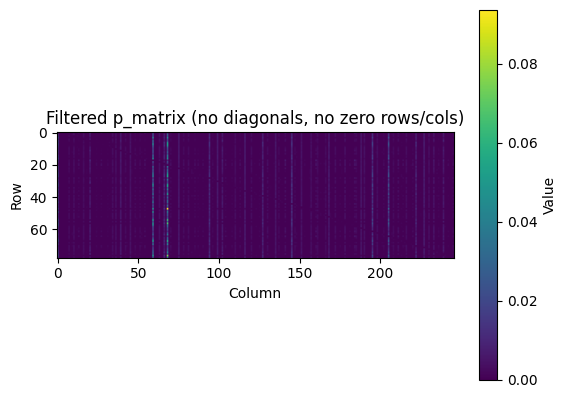

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# remove diagonals
p_no_diag = p_matrix.copy()
np.fill_diagonal(p_no_diag, 0)

# remove all-zero rows and columns
nonzero_rows = ~np.all(p_no_diag == 0, axis=1)
nonzero_cols = ~np.all(p_no_diag == 0, axis=0)
p_trimmed = p_no_diag[nonzero_rows][:, nonzero_cols]

# plot
plt.imshow(p_trimmed, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Filtered p_matrix (no diagonals, no zero rows/cols)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


In [231]:
p_no_diag.shape

(6084, 6084)

(6084,)


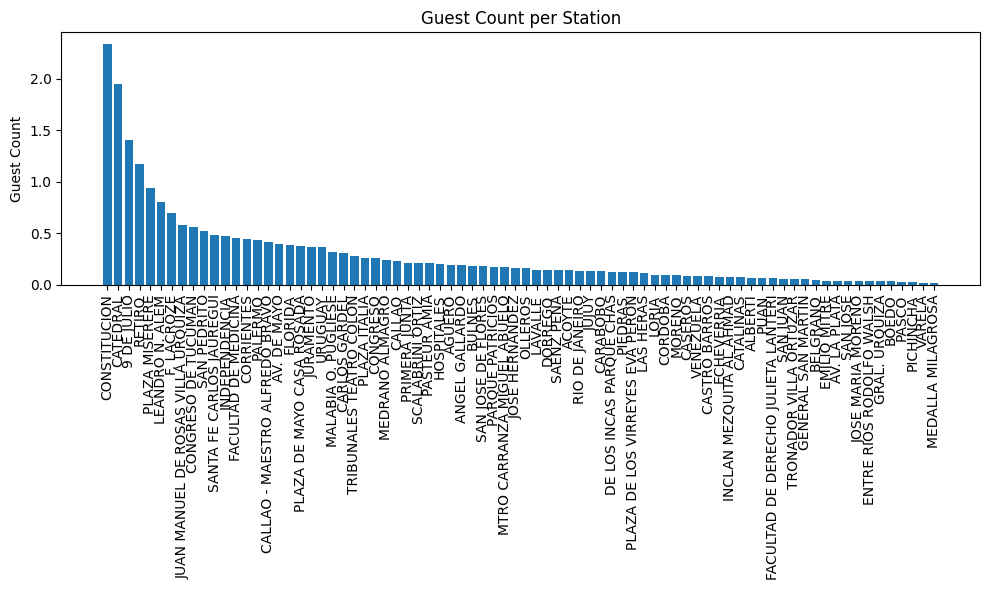

In [236]:
guest_arr = np.sum(p_no_diag,axis=0)
print(guest_arr.shape)
guest_arr = guest_arr[home_patches]

# Sort descending
sorted_pairs = sorted(zip(guest_arr, station_list), reverse=True)
sorted_guest, sorted_stations = zip(*sorted_pairs)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_stations, sorted_guest)
plt.ylabel('Guest Count')
plt.title('Guest Count per Station')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [239]:
len(home_patches)

78

In [18]:
def get_leg_infections(timesteps):
    day_range = timesteps
    def expand_array(short_array):
        long_array = np.zeros(6084)  # Create a zero array of the desired size

        # Assign values at the correct positions
        long_array[np.arange(78) * (78 + 1)] = short_array
        return long_array

    def expand_timeseries(short_timeseries):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((day_range,6084))
        for i in range(day_range):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries


    def compress_timeseries(long_timeseries):
        compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape

        for i in range(day_range):
            compressed[i] = compress_array(long_timeseries[i])

        return compressed.T  # Transpose back to match original input shape

    def compress_array(long_array):
        return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


    def expand_betas(short_betas,long_length):

        long_betas = np.zeros(long_length)
        index = 0
        for i in valid_patch_indices:
            long_betas[i] = short_betas[index]
            index += 1

        return long_betas



    with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
        pop_dict = pickle.load(file)

    # Assuming pop_dict is a pandas DataFrame
    pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
    pop_dict = dict(sorted(pop_dict.items()))

    # Extract values in order
    short_pop_vector = np.array(list(pop_dict.values()))

    pop_vector = expand_array(short_pop_vector)

    borough_list = np.array(range(15))+1

    with open("ba_big station list.pkl", "rb") as file:
        station_list = pickle.load(file)

    with open("station_comuna_dict.pkl", 'rb') as f:
        station_comuna_dict = pickle.load(f)

    station_borough_list = list(station_comuna_dict.values())

    with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
        props_dict = pickle.load(f)

    with open("BA_Covid_Data.pkl", 'rb') as f:
        covid_df = pickle.load(f)

    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure datetime and sort
    covid_df['date'] = pd.to_datetime(covid_df['date'])
    covid_df = covid_df.sort_values(['comuna', 'date'])

    # Filter out comunas 8–11
    df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

    # Create full MultiIndex for relevant comunas and dates
    all_dates = pd.date_range('2020-01-01', '2020-05-31')
    comunas = df_filtered['comuna'].unique()
    multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

    # Reindex and interpolate daily_cases
    df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
    df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

    # Identify missing comuna on April 23
    existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
    interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
    missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
    value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

    # Estimate total_cases using previous day's value
    prev_total = covid_df[
        (covid_df['comuna'] == missing_comuna) &
        (covid_df['date'] == pd.Timestamp('2020-04-22'))
    ]['total_cases'].values[0]
    estimated_total = prev_total + value

    # Create and insert new row
    new_row = {
        'date': pd.Timestamp('2020-04-23'),
        'comuna': missing_comuna,
        'daily_cases': value,
        'total_cases': estimated_total
    }
    covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
    covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

    # --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

    # Isolate comuna 6.0 from April 2 on
    comuna_df = covid_df[
        (covid_df['comuna'] == 6.0) &
        (covid_df['date'] >= '2020-04-02')
    ].sort_values('date').copy()

    # Get first known total_cases to anchor cumulative sum
    anchor_total = comuna_df.iloc[0]['total_cases']

    # Compute cumulative daily cases
    comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
    comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

    # Update total_cases in original covid_df
    covid_df.loc[
        (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
        'total_cases'
    ] = comuna_df['adjusted_total'].values


    with open("ba_all_paths.pkl", 'rb') as f:
        all_paths = pickle.load(f)

    # with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
        # commuter_array = pickle.load(file)


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    def get_timeseries(station_name,covid_df,props_dict):

        current_borough = props_dict[station_name][0]

        # Filter data for the given area_name "Lambeth" and within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] <= "2020-08-07") & 
            (covid_df['comuna'] == current_borough)
        ]

        # Find the earliest date where total_cases is nonzero
        # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
        earliest_nonzero_date = "2020-07-23"

        # Filter again using the adjusted start date
        filtered_df = filtered_df[
            (filtered_df['date'] >= earliest_nonzero_date) & 
            (filtered_df['date'] <= "2020-08-07")
        ]

        borough_timeseries = np.array(list(filtered_df['total_cases']))

        station_timeseries = props_dict[station_name][1]*borough_timeseries


        return station_timeseries

    def get_timeseries_with_five(station_name, covid_df, props_dict):
        current_borough = props_dict[station_name][0]

        # Define the start and end dates
        end_date = "2020-12-18"
        earliest_nonzero_date = "2020-04-05"
        five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

        # Filter data for the given borough within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] >= earliest_nonzero_date) & 
            (covid_df['date'] <= end_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        borough_timeseries = np.array(filtered_df['total_cases'])
        station_timeseries = props_dict[station_name][1] * borough_timeseries

        # Get new cases in the 5 days before the earliest nonzero date
        previous_df = covid_df[
            (covid_df['date'] >= five_days_before) & 
            (covid_df['date'] < earliest_nonzero_date) & 
            (covid_df['comuna'] == current_borough)
        ]

        total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

        return station_timeseries, total_new_cases_prev_5_days


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    all_station_timeseries = []
    all_new_cases_prev_5_days = []
    for i in range(len(station_list)):
        timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
        all_station_timeseries.append(timeseries[0])
        all_new_cases_prev_5_days.append(timeseries[1])


    all_station_timeseries = np.array(all_station_timeseries)
    day_range = all_station_timeseries[0].shape[0]
    print(day_range)

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    # Define main control panel functions

    # with open("London new Nj.pkl", "rb") as file:
        # Nj = pickle.load(file)

    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)

    # Load files
    with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
        sparse_p = pickle.load(file)

    p_matrix = sparse_p.toarray()
    Nj = pop_vector @ p_matrix
    
    Nj_safe = Nj.copy()
    Nj_safe[Nj_safe == 0] = 1
    Nj = Nj_safe.copy()
    

    with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
        valid_patches = pickle.load(f)

    with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
        valid_patch_indices = pickle.load(f)

    np.set_printoptions(suppress=True)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    current_cases,cum_cases

    # Define function to process solution
    def process_solution(solution,timesteps):
        # Grouping by station subpopulation
        S_sol = solution[:6084]
        I_sol = solution[6084:12168]
        I_sol_total = solution[12168:]

        return [S_sol,I_sol,I_sol_total]



    def run_model_London(params):
        S0,I0,I_total0,beta,gamma,timesteps = params

        if beta.shape[0]==246:
            beta = expand_betas(beta,6084)

        # Ensure no dividing by zero
        # Nj[Nj == 0] = 1

        # Set up initial y0 vector
        y0 = np.concatenate((S0,I0,I_total0))

        # beta_p_matrix = (beta*p_matrix.T).T
        # beta_p_matrix = beta[:, None] * p_matrix 
        beta_p_matrix = sparse_p.multiply(beta[:, None])

        t = np.linspace(0,timesteps-1,num=timesteps)



        def sir(y,timestep):
            S = y[:6084]
            I = y[6084:12168]
            I_total = y[12168:]

            dSdt = np.zeros_like(S)
            dIdt = np.zeros_like(I)
            dI_totaldt = np.zeros_like(I_total)

            Ij = p_matrix.T @ I


            method = "vector"

            if method == "vector":

                # Compute Ij_div_Nj efficiently
                Ij_div_Nj = Ij / Nj  # Shape (63001,)

                # Vectorized computation of infection terms using sparse matrix multiplication
                infection_terms = beta_p_matrix.multiply(S[:, None])  # (63001, 63001)
                infection_terms = infection_terms @ Ij_div_Nj  # (63001,)


                leg_infections = (beta_p_matrix.T).multiply(S) @ Ij_div_Nj
                
                # Update derivatives
                dSdt -= infection_terms
                dIdt += infection_terms


            else:
                leg_infections = np.zeros(6084)
                # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
                for i in valid_patch_indices:
                    for j in valid_patch_indices:
                        dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
                        leg_infections[j] += beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
                dIdt -= dSdt

            dI_totaldt += dIdt

            # Add the gamma terms
            dIdt -= gamma * I
            # dSdt += gamma * I

            # Concatenate results
            dx = np.concatenate((dSdt, dIdt, dI_totaldt))

            return dx, leg_infections[valid_patch_indices]

        y_log = np.zeros((len(t)+1,18252))
        y_log[0] = y0.copy()

        leg_infection_log = np.zeros((len(t),246))

        for step in range(len(t)):
            print("step:",step)
            results = sir(y_log[step],step)
            y_log[step+1] = y_log[step] + results[0]
            leg_infection_log[step] = results[1]

        solution = process_solution(y_log.T,timesteps)

        return solution, leg_infection_log


    def expand_timeseries(short_timeseries,timesteps=day_range):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((timesteps,6084))
        for i in range(timesteps):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    gamma = 1/5



    with open("Buenos Aires Home Patches.pkl", "rb") as file:
        home_patches = pickle.load(file)


    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    def make_detailed_beta(short_beta):
        new_beta_0 = np.zeros(246)

        for i in range(78):
            new_beta_0[i] = short_beta[i]
        for i in range(246-78):
            new_beta_0[i+251] = short_beta[-1]
        return np.array(new_beta_0)

    def expand_detailed_beta(detailed_beta):
        big_beta = np.zeros(6084)
        home_betas = detailed_beta[:78]
        travel_betas = detailed_beta[78:]
        big_beta[home_patches] = home_betas
        big_beta[travel_patches] = travel_betas

        return big_beta

    # Load best beta values
    with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
        best_beta_yet_0 = pickle.load(file)

    def expand_concise_betas(home_patches,travel_patches,concise_beta):
        long_beta = np.zeros(6084)
        for i in range(78):
            long_beta[home_patches[i]] = concise_beta[i]
        long_beta[travel_patches] = concise_beta[-1]

        return long_beta

    best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

    def plot_best_beta_vs_data(full_timeseries, pop_dict):
        """
        Extracts the relevant data, runs the SIR model with best_beta_yet, 
        and plots the beta values against the corresponding observed data.

        Parameters:
            full_timeseries (array-like): The full dataset of observed values.
            pop_dict (dict): Dictionary mapping population values.
        """
         # Load data
        working_timeseries = expand_timeseries(full_timeseries,day_range)

        short_pop_vector = np.array(list(pop_dict.values()))
        pop_vector = expand_array(short_pop_vector)

        day_list = np.arange(day_range)  # There are day_range days

        # Stack so each row is [day_index, corresponding 9 values]
        data = np.column_stack((day_list[:, None], working_timeseries))

        tspan = data[:, 0]
        timespan = tspan.shape[0] - 1
        gamma = 1 / 5



        I0 = expand_array(current_cases)
        S0 = pop_vector - I0
        I_total_0 = cum_cases

        params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
        solution = run_model_London(params)
        y = solution[0][1]
        leg_infections = solution[1]

        I_sum_model = compress_timeseries(y.T)
        raw_real_data = compress_timeseries(data.T[1:].T)
        normalizer = compress_array(pop_vector)[:, np.newaxis]
        test_data = I_sum_model / normalizer
        real_data = raw_real_data / normalizer

        # Get indices of the 10 stations with the highest total populations
        top_10_indices = np.argsort(-short_pop_vector)[:10]


        return np.array(y),params,leg_infections

    solution_model,params,leg_infections = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

    return solution_model, leg_infections

solution_legs, trial_legs = get_leg_infections(150)
solution_legs = solution_legs = solution_legs[..., 1:]
solution_legs = np.array([solution_legs,solution_legs,solution_legs])

/tmp/ipykernel_2071547/3856892334.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


258
step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 

In [19]:
timesteps = trial_legs.shape[0]
home_legs = []
travel_legs = []
idx = 0
for i in valid_patch_indices:
    if i in home_patches:
        home_legs.append(trial_legs.T[idx])
    elif i in travel_patches:
        travel_legs.append(trial_legs.T[idx])
    else:
        print("BAD")
        break
    idx += 1
home_legs = np.array(home_legs)
travel_legs = np.array(travel_legs)

pairs_list = []
for i in station_list:
    for j in station_list:
        pairs_list.append((i,j))
        
travel_leg_pairs_dict = {}
idx = 0
for i in travel_patches:
    travel_leg_pairs_dict[pairs_list[i]] = travel_legs[idx]
    idx += 1
    


In [403]:
import numpy as np
import pandas as pd
from itertools import combinations

def top_10_avg_pairs(data_dict):
    keys = list(data_dict.keys())
    pair_avgs = []
    for k1 in keys:
        avg_val = np.mean(data_dict[k1])
        pair_avgs.append((k1, avg_val))
    pair_avgs.sort(key=lambda x: x[1], reverse=True)
    return pair_avgs[:10]

def top_10_max_pairs(data_dict):
    keys = list(data_dict.keys())
    pair_maxes = []
    for k1 in keys:
        max_val = np.max(data_dict[k1])
        pair_maxes.append((k1, max_val))
    pair_maxes.sort(key=lambda x: x[1], reverse=True)
    return pair_maxes[:10]

def format_pairs_table(pair_list, value_name="Value"):
    return pd.DataFrame([
        {"Pair": f"{a} - {b}", value_name: val}
        for (a, b), val in pair_list
    ])

# Example usage:
avg_table = format_pairs_table(top_10_avg_pairs(travel_leg_pairs_dict), "Average")
max_table = format_pairs_table(top_10_max_pairs(travel_leg_pairs_dict), "Maximum")


In [404]:
avg_table

Pair   Average
0                       SAN JOSE - INDEPENDENCIA  0.559851
1                  DORREGO - MALABIA O. PUGLIESE  0.441813
2                     CARLOS GARDEL - CORRIENTES  0.439831
3                    PLAZA MISERERE - CORRIENTES  0.417685
4                MEDRANO ALMAGRO - CARLOS GARDEL  0.416458
5              AGUERO - SANTA FE CARLOS JAUREGUI  0.410241
6  PASTEUR AMIA - CALLAO - MAESTRO ALFREDO BRAVO  0.395688
7               ANGEL GALLARDO - MEDRANO ALMAGRO  0.376354
8               CALLAO - TRIBUNALES TEATRO COLON  0.368182
9                         LORIA - PLAZA MISERERE  0.362779

In [405]:
max_table

Pair   Maximum
0                       SAN JOSE - INDEPENDENCIA  2.247971
1                  DORREGO - MALABIA O. PUGLIESE  1.827373
2                     CARLOS GARDEL - CORRIENTES  1.780233
3                MEDRANO ALMAGRO - CARLOS GARDEL  1.691089
4              AGUERO - SANTA FE CARLOS JAUREGUI  1.678189
5                    PLAZA MISERERE - CORRIENTES  1.670580
6  PASTEUR AMIA - CALLAO - MAESTRO ALFREDO BRAVO  1.598367
7               ANGEL GALLARDO - MEDRANO ALMAGRO  1.538963
8               CALLAO - TRIBUNALES TEATRO COLON  1.503822
9                      SCALABRINI ORTIZ - BULNES  1.466326

In [406]:
travel_pop_dict = {}
for i in travel_patches:
    travel_pop_dict[pairs_list[i]] = Nj[i]
travel_pop_dict

{('9 DE JULIO', 'AV. DE MAYO'): np.float64(51.76549377375838),
 ('9 DE JULIO', 'CATEDRAL'): np.float64(79.23587070145123),
 ('9 DE JULIO', 'FLORIDA'): np.float64(51.1677611085086),
 ('9 DE JULIO', 'LAVALLE'): np.float64(61.48207323008965),
 ('9 DE JULIO', 'TRIBUNALES TEATRO COLON'): np.float64(55.66954281570841),
 ('9 DE JULIO', 'URUGUAY'): np.float64(48.777475742441254),
 ('ACOYTE', 'PRIMERA JUNTA'): np.float64(75.76516282445296),
 ('ACOYTE', 'RIO DE JANEIRO'): np.float64(167.30390160563377),
 ('AGUERO', 'BULNES'): np.float64(79.90255674551969),
 ('AGUERO', 'SANTA FE CARLOS JAUREGUI'): np.float64(229.32093043469416),
 ('ALBERTI', 'PASCO'): np.float64(75.52005158066824),
 ('ALBERTI', 'PLAZA MISERERE'): np.float64(18.88351710890697),
 ('ANGEL GALLARDO', 'MALABIA O. PUGLIESE'): np.float64(65.99773516728726),
 ('ANGEL GALLARDO', 'MEDRANO ALMAGRO'): np.float64(178.95924286116593),
 ('AV. DE MAYO', '9 DE JULIO'): np.float64(49.12049452565638),
 ('AV. DE MAYO', 'MORENO'): np.float64(122.0645

In [407]:
sorted_travel_pop = dict(sorted(travel_pop_dict.items(), key=lambda x: x[1], reverse=True))
sorted_travel_pop

{('SAN JOSE', 'INDEPENDENCIA'): np.float64(340.176228441964),
 ('PLAZA MISERERE', 'CORRIENTES'): np.float64(251.16409054325442),
 ('LORIA', 'PLAZA MISERERE'): np.float64(245.72745181647588),
 ('AGUERO', 'SANTA FE CARLOS JAUREGUI'): np.float64(229.32093043469416),
 ('CARLOS GARDEL', 'CORRIENTES'): np.float64(229.2223348742526),
 ('CASTRO BARROS', 'LORIA'): np.float64(221.32497211154057),
 ('ENTRE RIOS RODOLFO WALSH', 'SAN JOSE'): np.float64(218.15091678343822),
 ('PASTEUR AMIA',
  'CALLAO - MAESTRO ALFREDO BRAVO'): np.float64(212.2474746228323),
 ('CALLAO', 'TRIBUNALES TEATRO COLON'): np.float64(211.05283510385692),
 ('BOEDO', 'GRAL. URQUIZA'): np.float64(209.54249851998821),
 ('MEDRANO ALMAGRO', 'CARLOS GARDEL'): np.float64(209.54044906804648),
 ('SANTA FE CARLOS JAUREGUI',
  'FACULTAD DE MEDICINA'): np.float64(200.20222221976127),
 ('RIO DE JANEIRO', 'CASTRO BARROS'): np.float64(196.57494738422434),
 ('SCALABRINI ORTIZ', 'BULNES'): np.float64(196.54947170911313),
 ('DORREGO', 'MALABIA

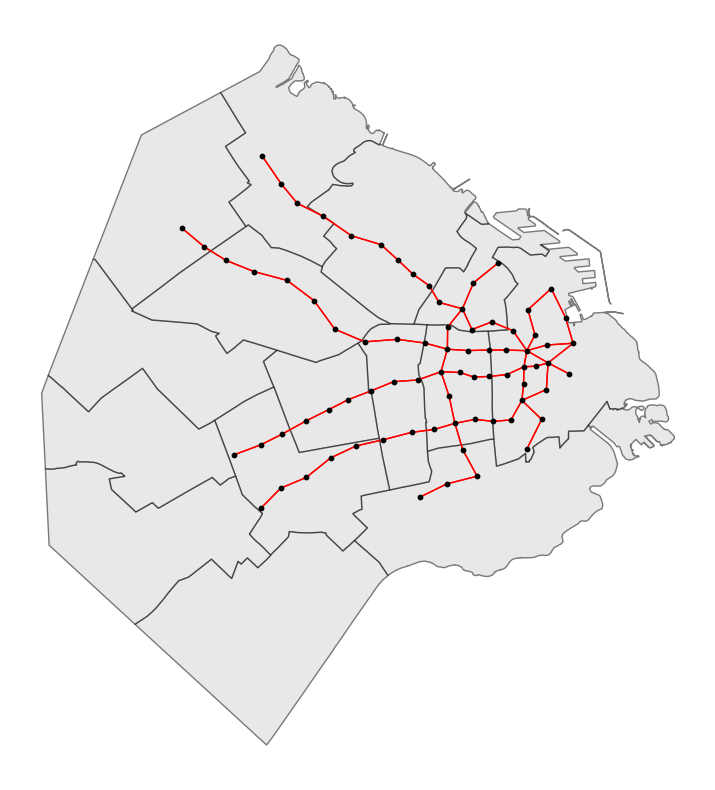

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Load Buenos Aires station and borough shapefiles
stations_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
boroughs_gdf = gpd.read_file("comunas.shp")

# Ensure consistent CRS
stations_gdf = stations_gdf.to_crs(epsg=3857)
boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

# Filter for stations in station_list
stations_gdf["name"] = station_list  # assume order aligns with home_patches
stations_gdf_filtered = stations_gdf[stations_gdf["name"].isin([s for pair in pairs_list for s in pair])]

# Create name-to-geometry mapping
station_geom = dict(zip(stations_gdf_filtered["name"], stations_gdf_filtered.geometry.centroid))

# Filter pairs using travel_patches indices
selected_pairs = [pairs_list[i] for i in travel_patches]

# Build LineStrings
lines = []
for s1, s2 in selected_pairs:
    if s1 in station_geom and s2 in station_geom:
        line = LineString([station_geom[s1], station_geom[s2]])
        lines.append({"station1": s1, "station2": s2, "geometry": line})

lines_gdf = gpd.GeoDataFrame(lines, geometry="geometry", crs=stations_gdf.crs)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
lines_gdf.plot(ax=ax, color="red", linewidth=1)
stations_gdf_filtered.geometry.centroid.plot(ax=ax, color="black", markersize=10, zorder=3)

ax.axis("off")
plt.show()


In [17]:
import networkx as nx

# Create graph
G = nx.Graph()
G.add_nodes_from(stations_gdf_filtered["name"])
G.add_edges_from(selected_pairs)

# Basic connectivity measures
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
density = nx.density(G)
num_components = nx.number_connected_components(G)

print(f"Average Degree: {avg_degree:.2f}")
print(f"Density: {density:.4f}")
print(f"Connected Components: {num_components}")
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")



Average Degree: 2.15
Density: 0.0280
Connected Components: 1
Average Clustering Coefficient: 0.0000


Average Clustering Coefficient: 0.0000000000


In [15]:
triangles = sum(nx.triangles(G).values()) // 3
print(f"Number of triangles: {triangles}")


Number of triangles: 0


In [409]:
def create_line_gif_with_date(travel_leg_pairs_dict, station_list, duration=0.1, output_filename="ba_transit_dynamics.gif"):
    # Load Buenos Aires shapefiles
    stations_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS consistency
    stations_gdf = stations_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add station names if not already present
    stations_gdf = stations_gdf.copy()
    stations_gdf["name"] = station_list  # assuming 1-to-1 correspondence with home_patches

    stations_gdf = stations_gdf[stations_gdf["name"].isin(station_list)]
    station_geom = dict(zip(stations_gdf["name"], stations_gdf.geometry.centroid))

    # Build line data
    seen = set()
    line_data = []
    for (s1, s2), values in travel_leg_pairs_dict.items():
        key = tuple(sorted((s1, s2)))
        if key in seen or s1 not in station_geom or s2 not in station_geom:
            continue
        seen.add(key)
        line_data.append({
            "s1": s1,
            "s2": s2,
            "geometry": LineString([station_geom[s1], station_geom[s2]]),
            "values": values
        })

    num_timesteps = len(next(iter(travel_leg_pairs_dict.values())))
    lines_gdf = gpd.GeoDataFrame(line_data, geometry="geometry", crs=stations_gdf.crs)
    start_date = datetime(2020, 3, 7)

    # Global normalization
    all_values = [val for ld in line_data for val in ld["values"]]
    vmin, vmax = min(all_values), max(all_values)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.plasma

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            lines_gdf["value"] = [ld["values"][t] for ld in line_data]
            values = lines_gdf["value"].values

            fig, ax = plt.subplots(figsize=(12, 10))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

            colors = [cmap(norm(val)) for val in values]
            lines_coords = [list(line.coords) for line in lines_gdf.geometry]

            sorted_indices = np.argsort(values)
            sorted_lines = [lines_coords[i] for i in sorted_indices]
            sorted_colors = [colors[i] for i in sorted_indices]

            lc = LineCollection(
                sorted_lines,
                colors=sorted_colors,
                linewidths=10,
                joinstyle="round",
                capstyle="round",
                zorder=2
            )
            ax.add_collection(lc)
            stations_gdf.geometry.centroid.plot(ax=ax, color="black", markersize=10, zorder=3)

            date_label = (start_date + timedelta(days=t)).strftime("%m/%d/%Y")
            ax.text(0.5, 1.02, date_label, transform=ax.transAxes, fontsize=14, ha="center", va="bottom", fontweight="bold")

            ax.axis("off")
            plt.tight_layout(pad=0.1)
            temp_filepath = os.path.join(temp_dir, f"frame_{t:03d}.png")
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            frames.append(imageio.imread(temp_filepath))

        imageio.mimsave(output_filename, frames, duration=duration, loop=0)
        IPython.display.clear_output(wait=True)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


create_line_gif_with_date(travel_leg_pairs_dict, station_list)

In [410]:
def create_combined_gif_ba(solution, params, travel_leg_pairs_dict, station_list, label_mode="date", duration=0.1, output_filename="combined_voronoi_lines_ba.gif"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add station names
    stations_gdf = voronoi_gdf.copy()
    stations_gdf["name"] = station_list  # assumes order aligns with home_patches
    stations_gdf = stations_gdf[stations_gdf["name"].isin(station_list)]
    station_geom = dict(zip(stations_gdf["name"], stations_gdf.geometry.centroid))

    # Normalize infected data by population
    pop_array = np.array(list(pop_dict.values()))
    station_data = solution[1][home_patches]
    for i in range(len(station_data)):
        station_data[i] = station_data[i] / pop_array[i]

    num_timesteps = station_data.shape[1]
    station_coords = np.stack([stations_gdf.geometry.centroid.x.values, stations_gdf.geometry.centroid.y.values], axis=1)

    # Line data setup
    seen = set()
    line_data = []
    for (s1, s2), values in travel_leg_pairs_dict.items():
        key = tuple(sorted((s1, s2)))
        if key in seen or s1 not in station_geom or s2 not in station_geom:
            continue
        seen.add(key)
        line_data.append({
            "s1": s1,
            "s2": s2,
            "geometry": LineString([station_geom[s1], station_geom[s2]]),
            "values": values
        })
    lines_gdf = gpd.GeoDataFrame(line_data, geometry="geometry", crs=voronoi_gdf.crs)

    # Global normalization for flows
    all_values = [val for ld in line_data for val in ld["values"]]
    vmin, vmax = min(all_values), max(all_values)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.plasma
    start_date = datetime(2020, 4, 5)

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Generating Combined Frames", unit="frame"):
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)
            voronoi_gdf["color"] = (color_values - color_min) / (color_max - color_min) if color_max > color_min else 0.5

            # Weighted center of infection
            weighted_x = np.sum(station_coords[:, 0] * station_data[:, t] * pop_array) / np.sum(station_data[:, t] * pop_array)
            weighted_y = np.sum(station_coords[:, 1] * station_data[:, t] * pop_array) / np.sum(station_data[:, t] * pop_array)

            lines_gdf["value"] = [ld["values"][t] for ld in line_data]
            values = lines_gdf["value"].values
            colors = [cmap(norm(val)) for val in values]
            lines_coords = [list(line.coords) for line in lines_gdf.geometry]
            sorted_indices = np.argsort(values)
            sorted_lines = [lines_coords[i] for i in sorted_indices]
            sorted_colors = [colors[i] for i in sorted_indices]

            fig, ax = plt.subplots(figsize=(10, 10))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)

            lc = LineCollection(
                sorted_lines,
                colors=sorted_colors,
                linewidths=6,
                joinstyle="round",
                capstyle="round",
                zorder=2
            )
            ax.add_collection(lc)

            stations_gdf.geometry.centroid.plot(ax=ax, color="black", markersize=10, zorder=3)
            ax.plot(weighted_x, weighted_y, marker='+', color='red', markersize=12, markeredgewidth=2)

            label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y") if label_mode == "date" else f"t = {t}"
            ax.text(0.5, 1.02, label_text, transform=ax.transAxes, fontsize=12, ha="center", va="bottom", fontweight="bold")
            ax.set_axis_off()
            plt.tight_layout(pad=0)

            temp_filepath = os.path.join(temp_dir, f"frame_{t:03d}.png")
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            frames.append(imageio.imread(temp_filepath))

        imageio.mimsave(output_filename, frames, duration=duration, loop=0)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


create_combined_gif_ba(
    solution=solution_legs,
    params=params,
    travel_leg_pairs_dict=travel_leg_pairs_dict,
    station_list=station_list,
    label_mode="date",
    duration=0.1,
    output_filename="combined_voronoi_lines_ba.gif"
)


Generating Combined Frames: 100%|██████████| 257/257 [01:07<00:00,  3.82frame/s]


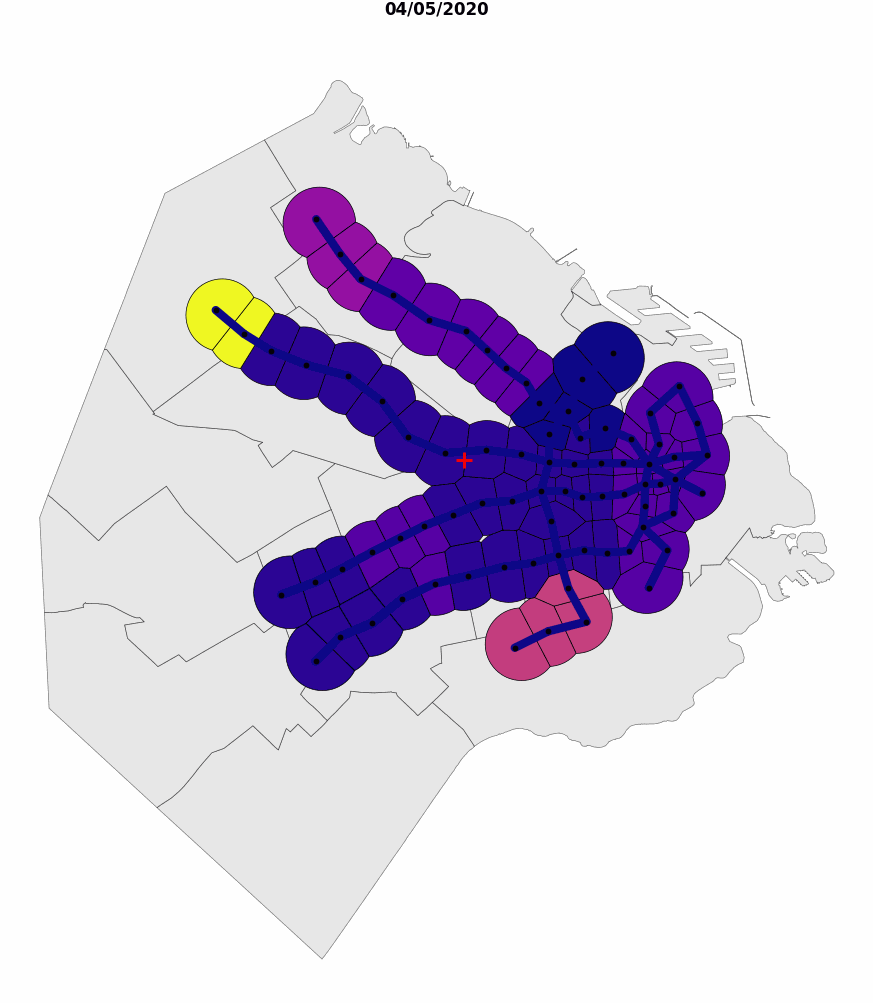

In [411]:
display_gif_with_speed("combined_voronoi_lines_ba.gif", speed_factor=3)  # much faster

In [222]:
myarr = np.array([
    [1,2,3],
    [4,5,6],
    [6,7,8]
])

np.sum(myarr,axis=0)

array([11, 14, 17])

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
69 SAN JUAN


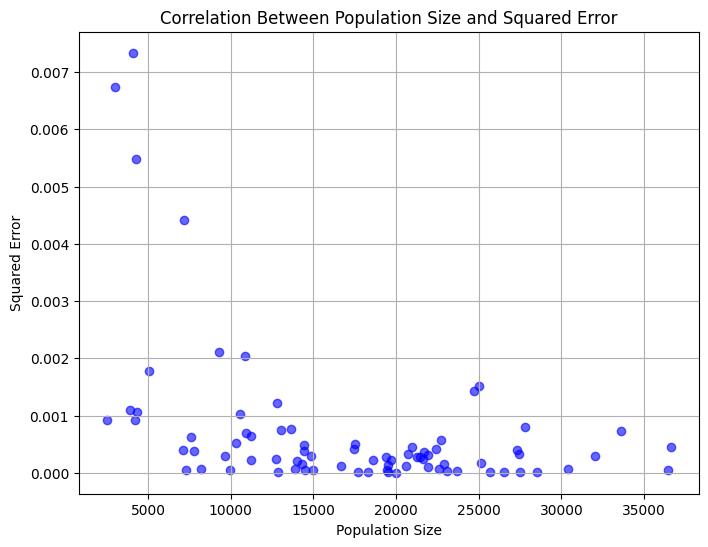

In [117]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pop_vs_error(pop_dict, full_timeseries):
    """
    Plots the correlation between population size and squared error for each station.

    Parameters:
        pop_dict (dict): Dictionary mapping station index to population size.
        full_timeseries (ndarray): Observed timeseries data.
    """
    working_timeseries = expand_timeseries(full_timeseries)  
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries)) 

    # Extract and expand population vector
    short_pop_vector = np.array(list(pop_dict.values()))  
    pop_vector = expand_array(short_pop_vector)  

    # Initialize SIR model parameters
    I0 = data[0, 1:]  
    S0 = pop_vector - I0  
    I_total_0 = np.zeros(6084)

    params = [S0, I0, I_total_0, best_beta_yet, 1 / 3, int(data[-1, 0])]
    y = run_model_London(params)[2]

    # Process model output
    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data[:, 1:])  

    normalizer = compress_array(pop_vector)[:, np.newaxis]  # Ensure correct shape

    # Normalize data
    real_data = raw_real_data / normalizer
    model_data = I_sum_model / normalizer

    # Compute squared errors
    squared_errors = np.sum((model_data - real_data) ** 2, axis=1)

    # Ensure station indices align properly
    station_pop_sizes = compress_array(pop_vector)
    worst_error = np.argmax(squared_errors)
    print(worst_error,station_list[worst_error])

    # Scatter plot of population size vs squared error
    plt.figure(figsize=(8, 6))
    plt.scatter(station_pop_sizes, squared_errors, color='b', alpha=0.6)
    plt.xlabel('Population Size')
    plt.ylabel('Squared Error')
    plt.title('Correlation Between Population Size and Squared Error')
    plt.grid(True)
    plt.show()

# Run the function
plot_pop_vs_error(pop_dict, all_station_timeseries)


In [25]:
result

array([3896.        , 3900.58508758, 3904.91895638, 3909.02541175,
       3912.92562869, 3916.63845865, 3920.18069939, 3923.5673325 ])

In [26]:
current_cases

array([1.42965438, 1.64875995, 3.47808462, 0.42369085, 1.69401405,
       0.92507048, 3.35081082, 4.02966309, 2.1651034 , 1.83156157,
       4.16248501, 0.39502726, 2.01005222, 1.17332923, 3.0832947 ,
       1.35001955, 2.63504925, 1.56280847, 0.6912931 , 4.53940334,
       7.57180622, 2.84020118, 0.60807483, 1.61165043, 1.7936081 ,
       5.48217908, 1.91632949, 1.05855612, 1.53761633, 5.27543823,
       0.58935304, 1.5838328 , 3.56011974, 1.15466004, 5.85901913,
       3.09189681, 3.41995754, 2.66223522, 1.76403149, 8.51782092,
       0.76107431, 2.79836144, 4.77052041, 1.86415719, 3.66524138,
       1.36006115, 1.9770448 , 1.98280183, 1.80867226, 1.50674359,
       2.87954089, 2.68784841, 2.09413796, 2.96578936, 0.57276726,
       0.56099807, 0.9594137 , 1.11428945, 1.78845115, 4.73047406,
       1.55905491, 0.69438223, 1.69190507, 1.89530349, 4.13478474,
       1.6221296 , 2.62804115, 3.0275034 , 1.77272366, 5.2630904 ,
       2.92999516, 2.47327055, 1.94785626, 2.79191232, 2.08008

In [96]:
with open("ba_new_paths.pkl", "rb") as file:
    paths = pickle.load(file)

paths

array([[None,
        list(['9 DE JULIO', 'AV. DE MAYO', 'SAENZ PENA', 'CONGRESO', 'PASCO', 'ALBERTI', 'PLAZA MISERERE', 'LORIA', 'CASTRO BARROS', 'RIO DE JANEIRO', 'ACOYTE']),
        list(['9 DE JULIO', 'TRIBUNALES TEATRO COLON', 'CALLAO', 'FACULTAD DE MEDICINA', 'SANTA FE CARLOS JAUREGUI', 'AGUERO']),
        ..., list(['9 DE JULIO', 'URUGUAY']),
        list(['9 DE JULIO', 'AV. DE MAYO', 'MORENO', 'INDEPENDENCIA', 'SAN JOSE', 'ENTRE RIOS RODOLFO WALSH', 'PICHINCHA', 'JUJUY', 'GRAL. URQUIZA', 'BOEDO', 'AV. LA PLATA', 'JOSE MARIA MORENO', 'EMILIO MITRE', 'MEDALLA MILAGROSA', 'VARELA']),
        list(['9 DE JULIO', 'URUGUAY', 'CALLAO - MAESTRO ALFREDO BRAVO', 'PASTEUR AMIA', 'CORRIENTES', 'PLAZA MISERERE', 'VENEZUELA'])],
       [list(['ACOYTE', 'RIO DE JANEIRO', 'CASTRO BARROS', 'LORIA', 'PLAZA MISERERE', 'ALBERTI', 'PASCO', 'CONGRESO', 'SAENZ PENA', 'AV. DE MAYO', '9 DE JULIO']),
        None,
        list(['ACOYTE', 'RIO DE JANEIRO', 'CASTRO BARROS', 'LORIA', 'PLAZA MISERERE', 'COR

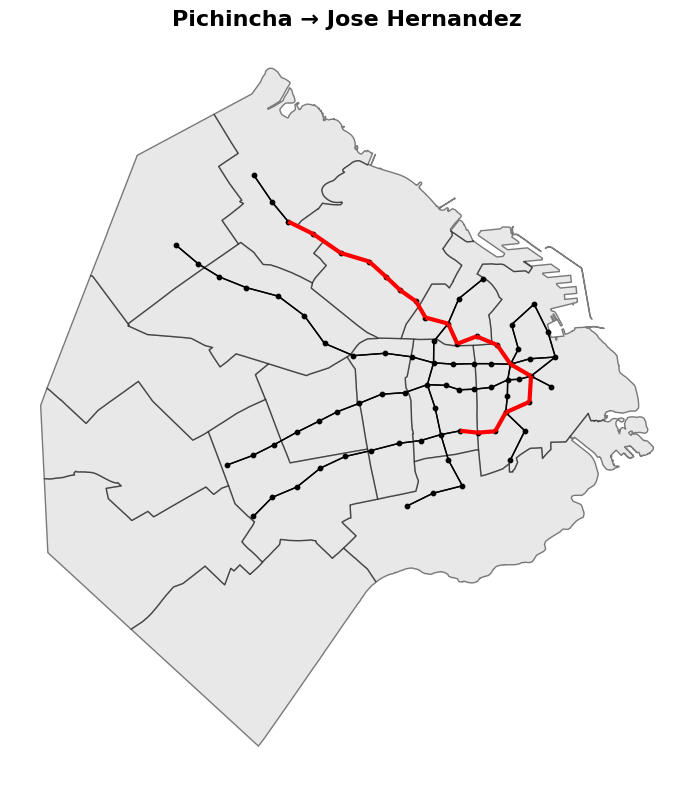

In [100]:
def plot_path_between_ba(station1, station2, paths, station_list, stations_gdf, boroughs_gdf, selected_pairs):
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from shapely.geometry import LineString

    # Setup
    stations_gdf = stations_gdf.copy()
    stations_gdf["name"] = station_list  # assumes order matches
    stations_gdf_filtered = stations_gdf[stations_gdf["name"].isin([s for pair in selected_pairs for s in pair])]
    station_geom = dict(zip(stations_gdf_filtered["name"], stations_gdf_filtered.geometry.centroid))

    # Base lines (gray)
    base_lines = []
    for s1, s2 in selected_pairs:
        if s1 in station_geom and s2 in station_geom:
            base_lines.append(LineString([station_geom[s1], station_geom[s2]]))
    base_lines_gdf = gpd.GeoSeries(base_lines, crs=stations_gdf.crs)

    # Target path (red)
    i, j = station_list.index(station1), station_list.index(station2)
    path = paths[i][j]
    red_lines = [LineString([station_geom[path[k]], station_geom[path[k+1]]]) 
             for k in range(len(path) - 1)
             if path[k] in station_geom and path[k+1] in station_geom]
    red_lines_gdf = gpd.GeoSeries(red_lines, crs=stations_gdf.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
    base_lines_gdf.plot(ax=ax, color="black", linewidth=1, zorder=1)
    red_lines_gdf.plot(ax=ax, color="red", linewidth=3, zorder=3)
    stations_gdf_filtered.geometry.centroid.plot(ax=ax, color="black", markersize=10, zorder=2)

    ax.set_title(f"{station1.title()} → {station2.title()}", fontsize=16, fontweight='bold')
    ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_path_between_ba("PICHINCHA", "JOSE HERNANDEZ", paths, station_list, stations_gdf, boroughs_gdf, selected_pairs)

